In [1]:
%matplotlib inline

In [404]:
import pandas as pd
import os
import shutil
from Bio import SeqIO
from Bio import AlignIO
import distance
import editdistance
import math
import subprocess
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections
import pybedtools
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
from scipy.stats import pearsonr as pearsonr

In [101]:
PAML_PATH = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/paml'
PROTEIN_DICT = {}
CDS_DICT = {}
PAIRING_DICT = {}
PROTEIN_DICT['DK0911'] = os.path.join(PAML_PATH, 'DK_0911_v04LT_ph_ctg.protein.fa')
PROTEIN_DICT['Pst104E'] = os.path.join(PAML_PATH, 'Pst_104E_v13_ph_ctg.protein.fa')
CDS_DICT['DK0911'] = os.path.join(PAML_PATH, 'DK_0911_v04LT_ph_ctg.cds.fa')
CDS_DICT['Pst104E'] = os.path.join(PAML_PATH, 'Pst_104E_v13_ph_ctg.cds.fa')
PAIRING_DICT['DK0911'] = os.path.join(PAML_PATH, 'DK.combined.paring')
PAIRING_DICT['Pst104E'] = os.path.join(PAML_PATH, 'PAu.combined.paring')
PAIRING_DICT['DK0911_ortho'] = os.path.join(PAML_PATH, 'DK.orthopairing')
PAIRING_DICT['Pst104E_ortho'] = os.path.join(PAML_PATH, 'PAu.orthopairing')
PAIRING_DICT['DK0911_synteny'] = os.path.join(PAML_PATH, 'DK.pairing')
PAIRING_DICT['Pst104E_synteny'] = os.path.join(PAML_PATH, 'PAu.pairing')


genomes = ['DK0911', 'Pst104E']
gene_keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']
n_threads = 10

In [38]:
DK0911_ortho_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/DK0911_vs_Ps104E_v13/'
Pst_104E_ortho_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/Ps104E_v13_vs_DK0911/'
DK0911_genome_file_fn = '/home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_ph_ctg.genome_file'
Pst_104E_genome_file_fn = \
'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_ph_ctg.genome_file'
WGA_PAA_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/mummer4'
LOWCOV_PAA_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping/filtered/'
ORTHOFINDER_FILE_NAME = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/result_update_redundant_protein_sets_01032019/Orthogroups_3_combined.csv'
OUT_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/downstream_analysis/'
ORTHOFINDER_FILE_NAME = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/result_update_redundant_protein_sets_01032019/Orthogroups_3_combined.csv'

In [39]:
###all the bedfiles
Pst_104E_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/Pst104E_annotations/'
Pst_104E_dict = {}
Pst_104E_dict['Busco'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.busco.gene.bed')
Pst_104E_dict['All_genes'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.genes.gene.bed')
Pst_104E_dict['Primary_genes'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_p_ctg.genes.gene.bed')
Pst_104E_dict['Secretome'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.secretome.gene.bed')
Pst_104E_dict['Ceffectors'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.ceffectors.gene.bed')
Pst_104E_dict['EffectorP'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.effectorp.gene.bed')
Pst_104E_dict['TE_superfamily'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')
Pst_104E_dict['Lowcov_01'] = os.path.join(LOWCOV_PAA_dir, 'Pst_104E_v13_ph_ctg.bwamem.DK0911_gDNA.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed')
Pst_104E_dict['WGA_95'] = os.path.join(WGA_PAA_dir, 'Pst_104E_v13_ph_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed')
Pst_104E_dict['Singletons'] = os.path.join(Pst_104E_ortho_dir,'190312_Ps104E_v13_vs_DK0911_singleton.csv')
Pst_104E_dict['Alleles'] = os.path.join(Pst_104E_ortho_dir, '190312_Ps104E_v13_vs_DK0911_allele.csv')
Pst_104E_dict['Paraloges'] = os.path.join(Pst_104E_ortho_dir, '190312_Ps104E_v13_vs_DK0911_paraloge.csv')

In [40]:
###all the bedfiles
DK0911_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/DK0911_annotations/'
DK0911_dict = {}
DK0911_dict['Busco'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.busco.gene.bed')
DK0911_dict['All_genes'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.genes.gene.bed')
DK0911_dict['Primary_genes'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_p_ctg.genes.gene.bed')
DK0911_dict['Secretome'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.secretome.gene.bed')
DK0911_dict['Ceffectors'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['EffectorP'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['TE_superfamily'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')
DK0911_dict['Lowcov_01'] = os.path.join(LOWCOV_PAA_dir, 'DK_0911_v04_ph_ctg.bwamem.Pst79_TS.RG.mark_dup.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed' )
DK0911_dict['WGA_95'] = os.path.join(WGA_PAA_dir, 'DK_0911_v04_ph_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed')
DK0911_dict['Singletons'] = os.path.join(DK0911_ortho_dir,'190506_DK0911_vs_Ps104E_v13_singleton.csv')
DK0911_dict['Alleles'] = os.path.join(DK0911_ortho_dir, '190506_DK0911_vs_Ps104E_v13_allele.csv')
DK0911_dict['Paraloges'] = os.path.join(DK0911_ortho_dir, '190506_DK0911_vs_Ps104E_v13_paraloge.csv')

In [45]:
beddicts = [DK0911_dict, Pst_104E_dict]

In [64]:
def get_gene_list(bed_fn):
    df = pd.read_csv(bed_fn, header=None, sep='\t')
    return df[3].unique()

In [8]:
def getFastaDict(fastaFile):
    d = {}
    for gene in SeqIO.parse(fastaFile, 'fasta'):
        d[gene.id] = gene
    return d

In [6]:
def writeAllelicFasta(alleleOne, alleleTwo, alleleType, fa_dict, outPath):
    '''writes fasta file containing fasta information for two alleles
    in the outPath'''
    assert(alleleType.upper() in ['CDS', 'GENE', 'PROTEIN'])
    
    alleleSeqRecords = []
    alleleSeqRecords.append(fa_dict[alleleOne])
    alleleSeqRecords.append(fa_dict[alleleTwo])
    
    with open(os.path.join(outPath, alleleType.lower() + '.fa'), 'w') as outFile:
        SeqIO.write(alleleSeqRecords, outFile, 'fasta')
    return True

def writeAlignmentScript(alleleOutPath, scriptLoc):
    with open(scriptLoc, 'a') as outFile:
        print('cd %s' % alleleOutPath, file=outFile)
        print('muscle -clwstrict -in protein.fa -out protein.aln', file=outFile)
        print('perl /home/benjamin/anaconda3/orthologr/inst/pal2nal/pal2nal.v14/pal2nal.pl -output paml protein.aln cds.fa > cds_codon.aln', file=outFile)
        print('perl /home/benjamin/anaconda3/orthologr/inst/pal2nal/pal2nal.v14/pal2nal.pl protein.aln cds.fa > cds_codon.clustal', file=outFile)
        print('cp %s/yn00.ctl ./' % PAML_PATH, file=outFile)
        print('yn00', file=outFile)
    return True

In [15]:
def prepareAlignmentBashScript(pairing_fn, protein_dict, cds_dict, script_fn, OUT_PATH):
    with open(script_fn, 'w') as pamlScript:
        print('#!/bin/bash', file=pamlScript)
    
    df = pd.read_csv(pairing_fn, sep='\t', header=None, names=['Query', 'Target'])
    
    for index, [Query, Target] in df.iloc[:, :2].iterrows():

        alleleOutPath = os.path.join(OUT_PATH, '%s_%s' % (Query, Target))
        if not os.path.exists(alleleOutPath):
            os.mkdir(os.path.join(OUT_PATH, '%s_%s' % (Query, Target)))

        writeAllelicFasta(Query, Target, 'CDS', cds_dict, alleleOutPath)
        writeAllelicFasta(Query, Target, 'PROTEIN', protein_dict, alleleOutPath)

        writeAlignmentScript(alleleOutPath, script_fn)
    return True

In [25]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return it.zip_longest(*args, fillvalue=fillvalue)

In [26]:
def combineTmpToDf(header, suffix, tmp_path, clean=True):
    """Combines the files of a temporary folder into a dataframe based on the tmp files
    suffix. Returns combined dataframe. And cleans up if needed."""
    tmp_assigneddfs_fh = [os.path.join(tmp_path, file) for file in os.listdir(tmp_path)\
                         if file.endswith(suffix) ]
    print(len(tmp_assigneddfs_fh))
    tmp_df = pd.DataFrame(columns=header)
    for df_fh in tmp_assigneddfs_fh:
        tmp_df = pd.concat([tmp_df, pd.read_csv(df_fh, index_col = 0, sep='\t')])
    if clean == True:
        #now clean up again
        for file in tmp_assigneddfs_fh:
            os.remove(file)
    return tmp_df

In [24]:
def assignDistancesToAlleles(folder, alignmentFile, alleleType):
    '''Adds Hamming and Levenshtein distance columns to an allele pair
    (indexed by 'folder' name) in df'''
    #print(folder)
    if pd.isnull(folder):
        return np.nan, np.nan
    assert(alleleType.upper() in ['PROTEIN', 'CDS', 'GENE'])
    seq1, seq2 = AlignIO.read(open(alignmentFile, 'r'), format='clustal', seq_count=2)
    seq1 = str(seq1.seq).upper()
    seq2 = str(seq2.seq).upper()
    assert(len(seq1) == len(seq2))
    return editdistance.eval(seq1, seq2)/len(seq1), distance.hamming(seq1, seq2, normalized=True)

def assignDistancesToAllAlleles(df_folder_index, all_folders, tmp_path, base_path, suffix):
    """
    Reads in the index that contains the folder pairings for the alignements.
    Returns a protein_df and CDS_df that contain the hamming and levenshtein distance each.
    """
    cleaned_index = [x for x in df_folder_index if x in all_folders]
    count = 0
    total = len(df_folder_index)
    percentDone = 0
    protein_lev_dict = {}
    protein_ham_dict = {}
    CDS_lev_dict = {}
    CDS_ham_dict = {}
    
    #print("Calculating distances and adding them to the allele DataFrame...")
    
    for folder in cleaned_index:
        if pd.isnull(folder):
            proteinAlignmentFile = ''
            cdsAlignmentFile = ''
        else:
            proteinAlignmentFile = os.path.join(base_path, folder, 'protein.aln')
            cdsAlignmentFile = os.path.join(base_path, folder, 'cds_codon.clustal')
        #here the nan get overwritten. This doesn't matter though as they are all
        #nan anyway.
        protein_lev_dict[folder], protein_ham_dict[folder]  = \
        assignDistancesToAlleles(folder, proteinAlignmentFile, 'PROTEIN')
        CDS_lev_dict[folder], CDS_ham_dict[folder]  = \
        assignDistancesToAlleles(folder, cdsAlignmentFile, 'CDS')

        count += 1
        #if round(count/total * 100) > percentDone:
            #percentDone = round(count/total * 100)
            #print("%s%% complete" % percentDone)
            
    newdf_columns=['protein_hamming', 'protein_levenshtein', 'cds_hamming',
       'cds_levenshtein']
    if len(protein_ham_dict) > 0:
        df = pd.DataFrame([protein_ham_dict,protein_lev_dict,CDS_ham_dict,CDS_lev_dict]).T
        df.rename(columns=dict(zip(df.columns,newdf_columns)),inplace=True)
        out_name = os.path.join(tmp_path, '%s_%s.%s' % (df.index[0],df.index[-1],suffix))
        df.round(4).to_csv(out_name, sep='\t')

In [27]:
def parse_dNdS_to_df(line, folder):
    """
    Function that parses out dN and dS of a yn00 file and calls the 
    assign_dNdS function. Therefore returns a single element
    pd.Series with folder name as index.
    """
    dN = re.findall(r'dN = [-| ]?(.*) w', line)[0]
    dS = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
    return assign_dNdS(dN, dS, folder)

def assign_dNdS(dN, dS, folder):
    '''
    Function that cacluates the dN/dS ratio an returns it as a series usind the folder as index.
    Input: dN, dS, folder(name)
    Output: single element pd.Series with folder name as index.
    '''
    if float(dS) > 0:
        series = pd.Series([float(dN)/float(dS)], index=[folder])
    else:
        series = pd.Series([np.nan], index=[folder])
    return series

def assign_dNdS_to_all_alleles(folder_index, all_folders, tmp_path, base_path, suffix):
    """Function that parses out the different dN/dS ratios from a yn.out file for a list/index
    of folders that contain these yn.out files. The output dataframe is saved to tmp folder using
    the suffix.
    Input:  folder_index, list or index where to find the yn.out for each pairing.
            all_folders, are all possible folders. This is used to filter out nan and so from
                paralizing etc.
            tmp_path, is the path were 
    Output: Saved out tmp df with the suffix as file ending.
    
    """
    cleaned_index = [x for x in folder_index if x in all_folders]
    #print(cleaned_index)
    yn00_s = pd.Series([], name='yn00_dN/dS')
    LWL85_s = pd.Series([], name='LWL85_dN/dS')
    LWL85m_s = pd.Series([], name='LWL85m_dN/dS')
    LPB93_s = pd.Series([], name='LPB93_dN/dS')
    #header = ['folder','yn00_dN/dS', 'LWL85_dN/dS','LWL85m_dN/dS','LPB93_dN/dS']
    #append these list
    for folder in cleaned_index:
        alleleYn = os.path.join(base_path, folder,'yn.out')
        with open(alleleYn, 'r') as ynOut:
            #now loop over the lines and parse out stuff
            for i, line in enumerate(ynOut):
                if line.startswith('seq. seq. ') and i > 0:
                    next(ynOut) # we want the line that is two after the line starting with 'seq. seq '
                    dataLine = next(ynOut)
                    dN = dataLine.split('+-')[0].rstrip().split(' ')[-1]
                    dS = dataLine.split('+-')[1].rstrip().split(' ')[-1]
                    yn00_s = yn00_s.append(assign_dNdS(dN, dS, folder))
                elif line.startswith('LWL85:') and 'nan' not in line:
                    LWL85_s = LWL85_s.append(parse_dNdS_to_df(line, folder))
                elif line.startswith('LWL85m:') and 'nan' not in line:
                    LWL85m_s= LWL85m_s.append(parse_dNdS_to_df(line, folder))
                elif line.startswith('LPB93:') and 'nan' not in line:
                    LPB93_s =LPB93_s.append(parse_dNdS_to_df(line, folder))
                else:
                    continue
    out_df = pd.concat([yn00_s.round(4),LWL85_s.round(4),\
                        LWL85m_s.round(4), LPB93_s.round(4)],axis =1)
    new_columns = ['yn00_dN/dS','LWL85_dN/dS','LWL85m_dN/dS','LPB93_dN/dS' ]
    if len(out_df) > 0:
        out_df.rename(columns=dict(zip(out_df.columns, new_columns)), inplace=True)
        out_name = os.path.join(tmp_path, '%s_%s.%s' % (out_df.index[0],out_df.index[-1],suffix))
        out_df.to_csv(out_name, sep='\t')
    #return out_df

In [42]:
def add_gentype_column(df, gene_type_list, genome, bed_fn_dict):
    """A function that takes a collinear dataframe, a gentype list, a genome name and a dictionary
    that contains the filenames for bedfiles of genes belonging to different genetypes.
    The function adds a new column to the df with False/True to belonging to the genetype."""
    for gene_type in gene_type_list:
        tmp_index = df[genome].isin(get_gene_list(bed_fn_dict[gene_type]))
        key = '%s_%s' % (genome, gene_type)
        df[key] = False
        df.loc[tmp_index, key] = True
    return df

In [9]:
protein_dict = {}
for genome in genomes:
    protein_dict.update(getFastaDict(PROTEIN_DICT[genome]))

In [21]:
cds_dict = {}
for genome in genomes:
    cds_dict.update(getFastaDict(CDS_DICT[genome]))

In [22]:
for genome in genomes:
    BASE_OUT = os.path.join(PAML_PATH, genome)
    if not os.path.exists(BASE_OUT):
        os.makedirs(BASE_OUT)
    paml_script_fn = os.path.join(BASE_OUT, 'paml_script.sh')
    prepareAlignmentBashScript(PAIRING_DICT[genome], protein_dict, cds_dict, paml_script_fn, BASE_OUT)

#### Execute both paml scripts on the command line

In [33]:
GENEMATCHDICT = {}
for genome in genomes:
    BASE_OUT = os.path.join(PAML_PATH, genome)
    if not os.path.exists(BASE_OUT):
        os.makedirs(BASE_OUT)
        
    #prepare the genematch dataframe    
    genematchDf = pd.read_csv(PAIRING_DICT[genome], sep='\t',\
                              header=None, names=['Query', 'Target'])
    genematchDf['folder'] = genematchDf.Query +'_' + genematchDf.Target
    genematchDf.set_index('folder', inplace=True)
    
    analysedAllelesPath = os.path.join(BASE_OUT, genome+'_analysed_genematch.df') 
    GENEMATCHDICT[genome] = analysedAllelesPath
    all_folders = genematchDf.index
    #generate a tmp folder for the parallized analysis
    tmp_path = os.path.join(BASE_OUT, 'tmp')
    if not os.path.exists(tmp_path):
        os.mkdir(tmp_path)
    #assign the distances
    dist_suffix = 'distdf_tmp'
    Parallel(n_jobs=n_threads)(delayed(assignDistancesToAllAlleles)\
                (list(folder_index_list),all_folders,tmp_path, BASE_OUT, dist_suffix)\
                       for folder_index_list in grouper(genematchDf.index, 100, np.nan))
    distdf_header = ['protein_hamming', 'protein_levenshtein', 'cds_hamming',
       'cds_levenshtein']
    distdf = combineTmpToDf(distdf_header, dist_suffix, tmp_path, clean=True)
    distdf['Index'] = distdf.index
    genematchDf['Index'] = genematchDf.index
    tmp_df = pd.merge(genematchDf, distdf,how='inner')
    tmp_df.to_csv(analysedAllelesPath, sep='\t')
    print("Done with caculate pairwise alignment distances.")
    #pd.util.testing.assert_frame_equal(alleleDf, pd.read_csv(analysedAllelesPath, sep='\t', index_col=0))
    print("Starting to parse dN/dS ratios from yn.out file.")
    
    dNdS_suffix = 'dNdSdf_tmp'
    #now assign the dNdS ratios
    Parallel(n_jobs=n_threads)(delayed(assign_dNdS_to_all_alleles)\
                        (list(folder_index_list),all_folders,tmp_path, BASE_OUT, dNdS_suffix)\
                       for folder_index_list in grouper(genematchDf.index, 100, np.nan))
    dNdS_header = ['yn00_dN/dS','LWL85_dN/dS','LWL85m_dN/dS','LPB93_dN/dS' ]
    dNdSdf = combineTmpToDf(dNdS_header, dNdS_suffix, tmp_path, clean=True)
    dNdSdf['Index'] = dNdSdf.index
    tmp_df = pd.merge(tmp_df, dNdSdf,how='inner')
    tmp_df.to_csv(analysedAllelesPath, sep='\t')
    print('Finish to parse dN/dS ratios.')

248
Done with caculate pairwise alignment distances.
Starting to parse dN/dS ratios from yn.out file.


/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pa

248
Finish to parse dN/dS ratios.
290
Done with caculate pairwise alignment distances.
Starting to parse dN/dS ratios from yn.out file.


/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pa

290
Finish to parse dN/dS ratios.


In [41]:
#looking good now add the gene categories and if the genes are from synteny or orthology

In [78]:
GENEMATCHDFDICT = {}

In [277]:
for genome, bed_dict in zip(genomes, beddicts):

    tmp_df = pd.read_csv(GENEMATCHDICT[genome], sep='\t')
    tmp_df.drop(['Index', 'Unnamed: 0'], inplace=True, axis=1)

    if genome == 'DK0911':
        tmp_df.rename(columns=dict(zip(['Query', 'Target'], genomes)), inplace=True)
    elif genome == 'Pst104E':
        genomes.reverse()
        tmp_df.rename(columns=dict(zip(['Query', 'Target'], genomes)), inplace=True)
        genomes.reverse()
    
    missing_genes = set(get_gene_list(bed_dict["All_genes"])) - set(tmp_df[genome])
    addondf = pd.DataFrame(columns=tmp_df.columns)
    addondf[genome] = pd.Series(list(missing_genes))
    tmp_df = pd.concat([tmp_df, addondf])
    tmp_df.reset_index(drop=True, inplace=True)
    
    for cgenome in genomes:
        tmp_df = add_gentype_column(tmp_df, gene_keys, cgenome, bed_dict)
    
    tmp_df['Match_type'] = None
    for matchtype in ['ortho' , 'synteny']:
        tmp_index = tmp_df[tmp_df[genome]\
                           .isin(pd.read_csv(PAIRING_DICT[genome+'_'+matchtype], header=None, sep='\t')\
                                 [0].tolist())].index
        tmp_df.loc[tmp_index, 'Match_type'] = matchtype
    
    
    GENEMATCHDFDICT[genome] = tmp_df
genomes = ['DK0911', 'Pst104E']

In [278]:
GENEMATCHDFDICT['Pst104E']['Match_type'].unique()

array(['ortho', 'synteny', None], dtype=object)

In [279]:
GENEMATCHDFDICT['Pst104E'].tail()

,Pst104E,DK0911,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,...,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst104E_All_genes,Pst104E_Busco,Pst104E_Ceffectors,Pst104E_EffectorP,Pst104E_Secretome,Match_type
30244,Pst104E_09458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,True,False,False,False,None
30245,Pst104E_19341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,None
30246,Pst104E_10827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,None
30247,Pst104E_11191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,None
30248,Pst104E_06382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,None


In [280]:
tmp_df.head()

,Pst104E,DK0911,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,...,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst104E_All_genes,Pst104E_Busco,Pst104E_Ceffectors,Pst104E_EffectorP,Pst104E_Secretome,Match_type
0,Pst104E_18206,DK0911_30030,0.8480,0.8480,0.8423,0.8397,0.7592,0.7774,0.7307,0.7776,...,False,False,False,False,True,False,False,False,False,ortho
1,Pst104E_29488,DK0911_06256,0.2134,0.2134,0.1636,0.1616,0.3598,0.3006,0.3261,0.3828,...,False,False,False,False,True,False,False,False,False,ortho
2,Pst104E_25028,DK0911_13770,0.8104,0.8104,0.8104,0.8104,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho
3,Pst104E_28456,DK0911_12480,0.6893,0.6893,0.6610,0.6573,0.3860,0.3324,0.4684,0.3753,...,False,False,False,False,True,False,False,False,False,ortho
4,Pst104E_06991,DK0911_26923,0.7500,0.7500,0.7280,0.7198,0.2355,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho


In [620]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 14}

matplotlib.rc('font', **font)

DK0911
Pst104E


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


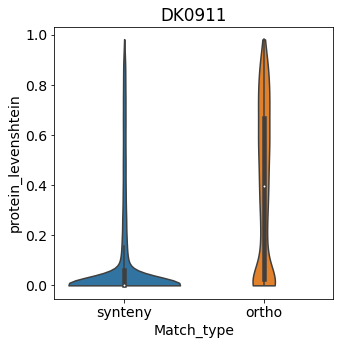

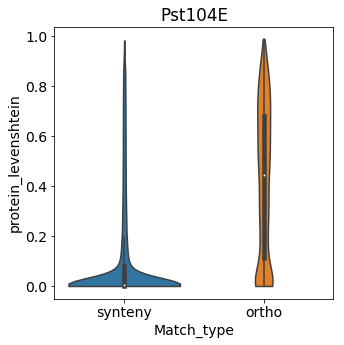

In [282]:
for genome in genomes:
    print(genome)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.violinplot(y='protein_levenshtein', x='Match_type', data=GENEMATCHDFDICT[genome], cut=0, ax=ax,\
                  order=['synteny','ortho'])
    plt.title(genome)

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


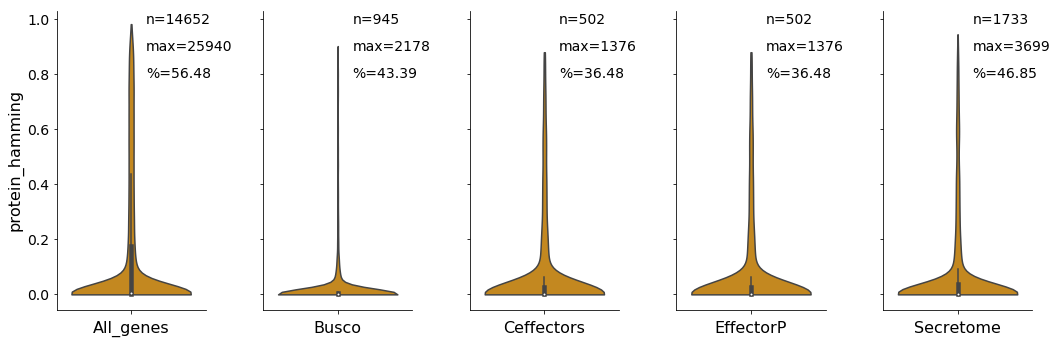

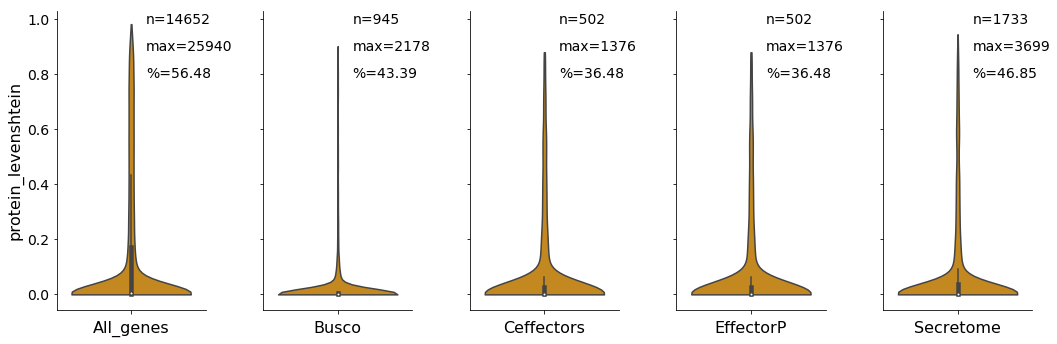

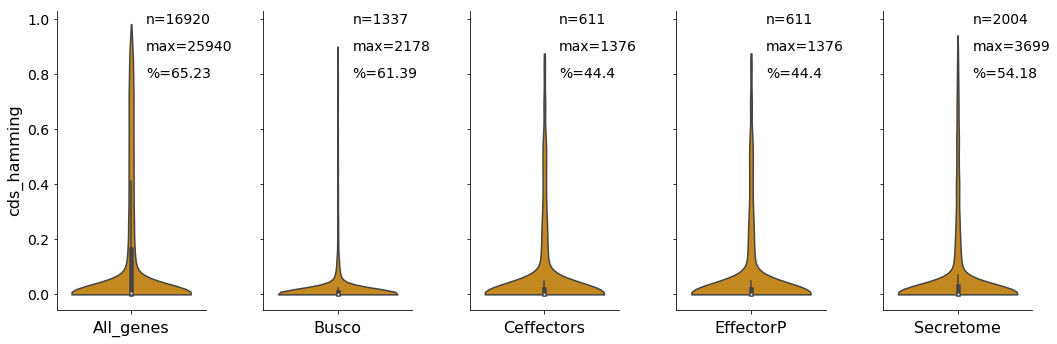

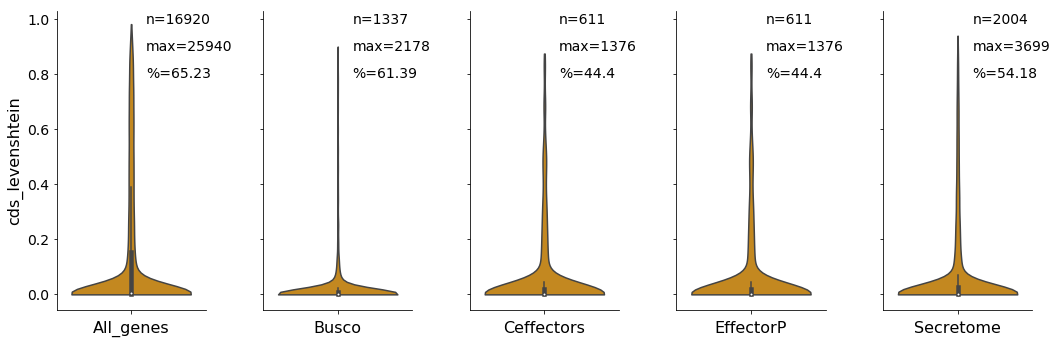

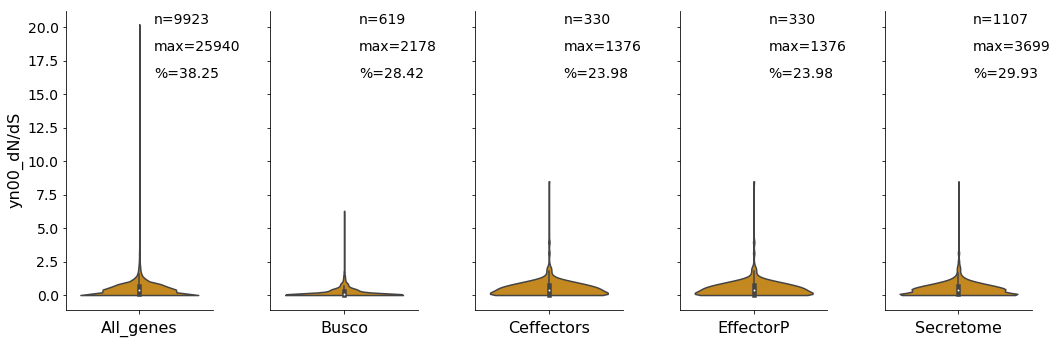

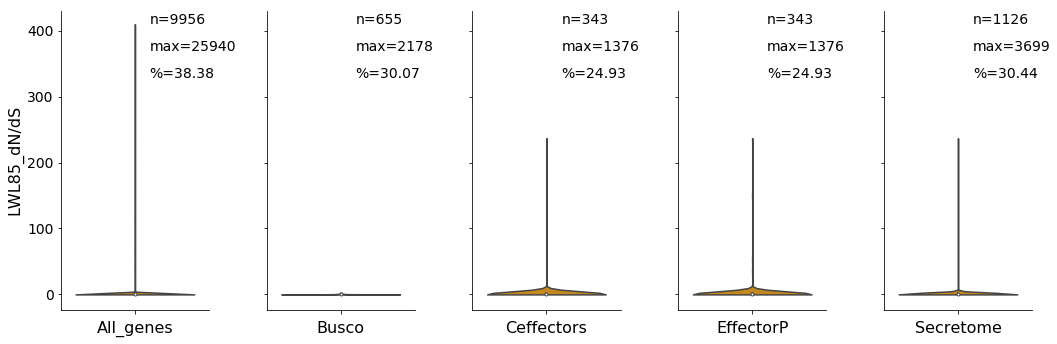

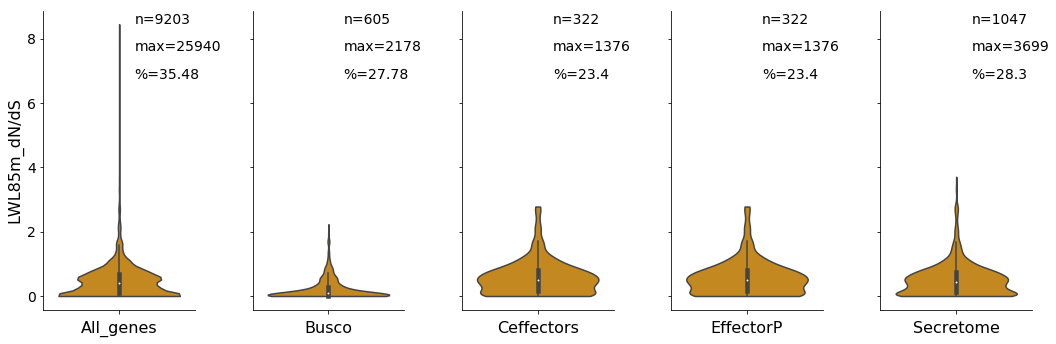

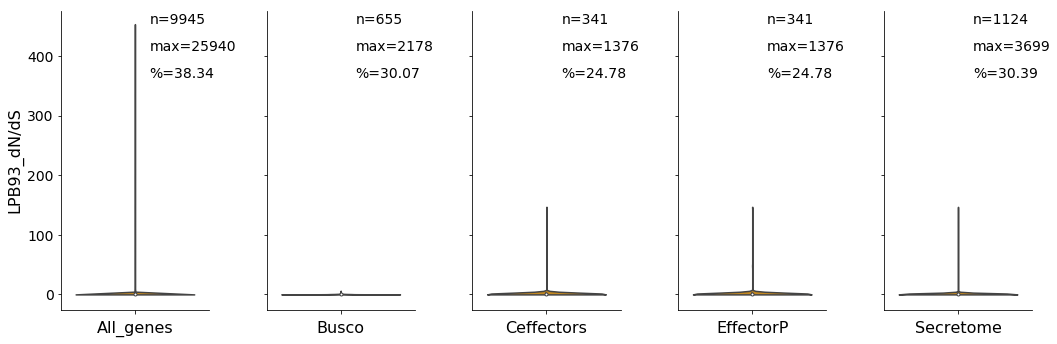

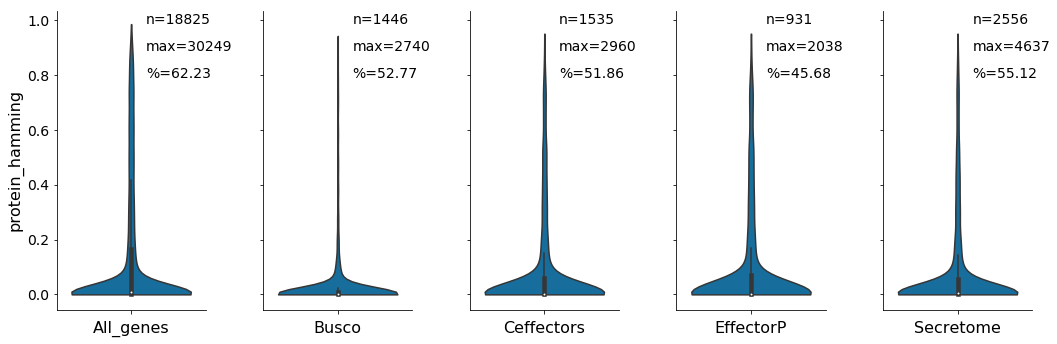

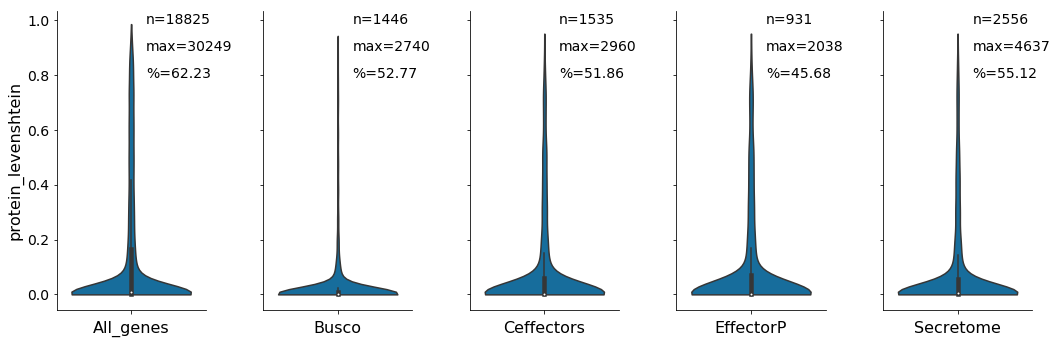

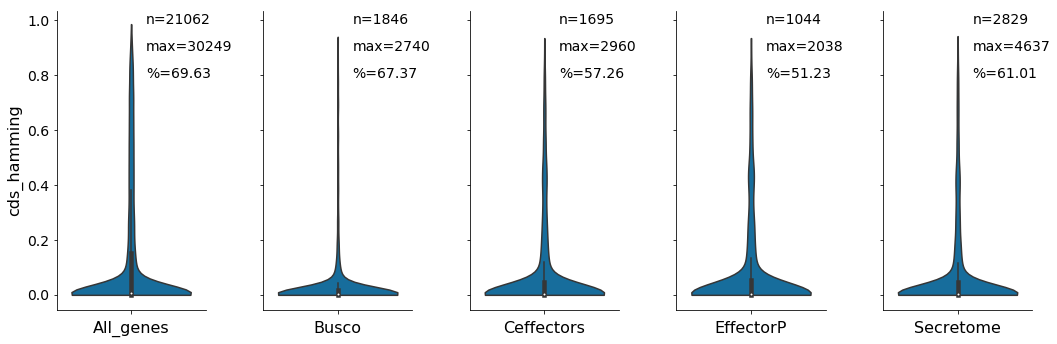

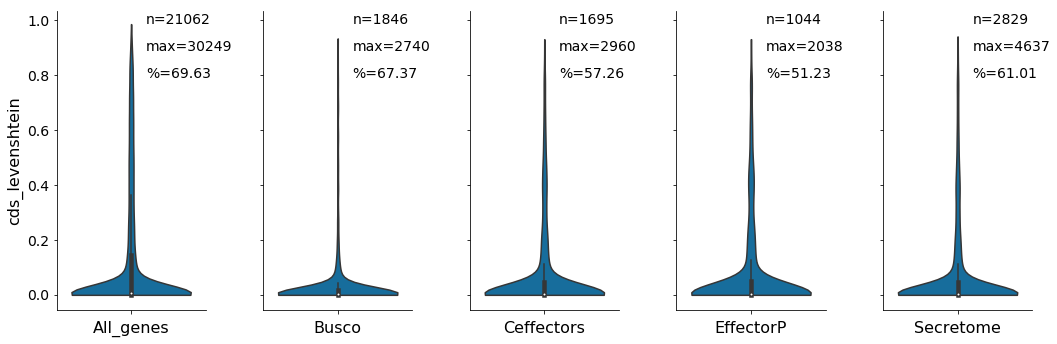

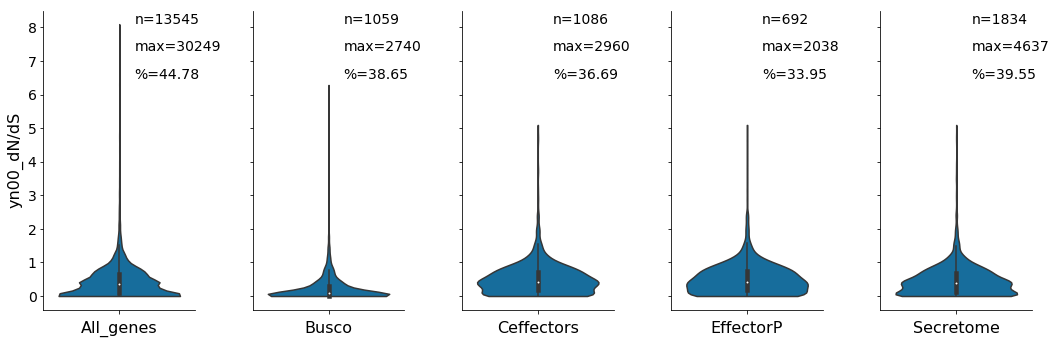

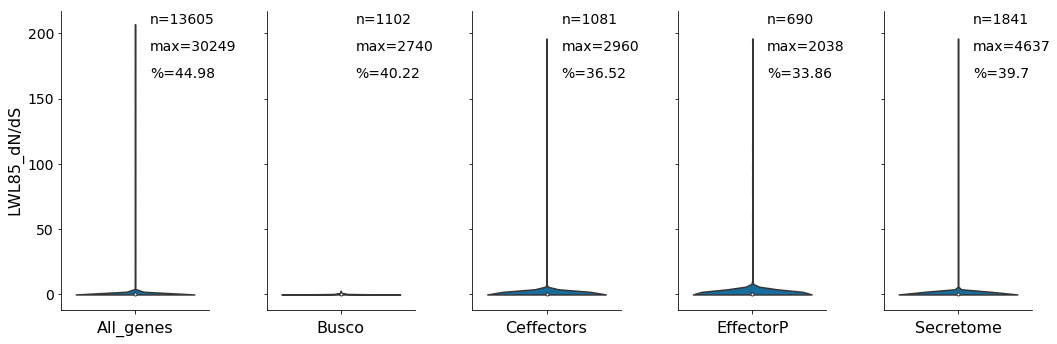

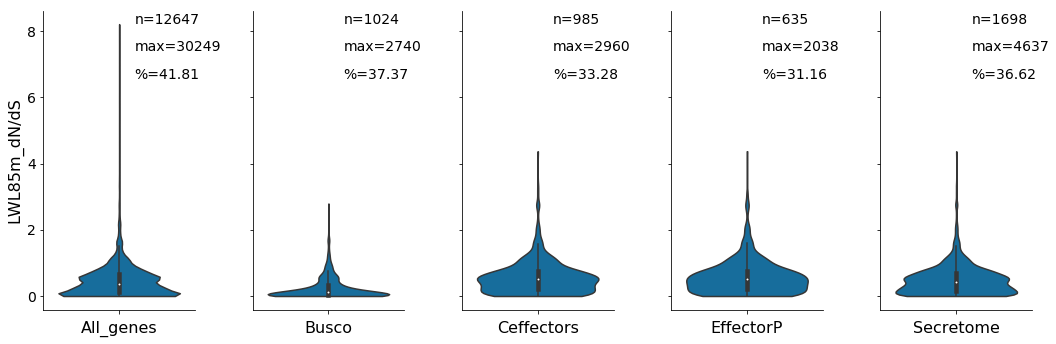

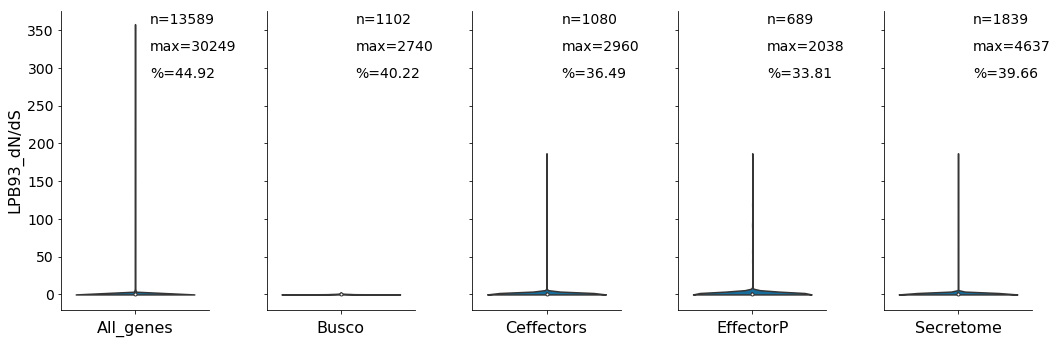

In [174]:
pallete = [sns.color_palette('colorblind')[x] for x in [1,0]]

#needs fixing for the n calculation
#think about variation and synteny block length or gaps. This might be interesting.


for genome, color, genome_dict in zip(genomes, pallete, beddicts): 
    tmp_df = GENEMATCHDFDICT[genome]
    columns = [x for x in tmp_df.columns if x.startswith(genome + '_')]
    value_columns = ['protein_hamming', 'protein_levenshtein',
       'cds_hamming', 'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS',
       'LWL85m_dN/dS', 'LPB93_dN/dS']
    for n, value in enumerate(value_columns):
        tmp_df_columns = []
        tmp_df_columns.append(genome)
        tmp_df_columns.append(value)
        tmp_df_columns.append('Match_type') 
        tmp_df_columns = tmp_df_columns + columns
        #tmp_df = tmp_df.loc[:, tmp_df_columns]
        #tmp_df = tmp_df[tmp_df.value]
        plot_variation(genome, tmp_df.loc[:, tmp_df_columns], value,  color, 'something')

In [173]:
def plot_variation(genome, df, value,  color, out_fn):
   
    columns = [x for x in df.columns if genome in x][1:]
    
    f1, ax = plt.subplots(1, len(columns), figsize=(15, 5), sharey=True)
    
    for n, column in enumerate(columns):
        if genome == 'DK0911':
            _dict = DK0911_dict
        elif genome =='Pst104E':
            _dict = Pst_104E_dict
    
        max_genes = len(get_gene_list(_dict[column.replace(genome+'_','')]))
        
        
        sns.violinplot(y=df[df[column] == True][value], color=color, ax=ax[n], cut =0)
        #ax[y[0], y[1]].axhline(y=overlap, color='r', linestyle='-')
        #ax[n].set_title(column, fontsize=16)
        #ax[y[0], y[1]].set_yticklabels([])
        ax[n].set_ylabel('')
        ax[n].set_xlabel(column.replace(genome+"_",''), fontsize=16)
        
        y_text_start_value = df[value].max()
        
        ax[n].text(0.1, y_text_start_value, 'n=%s' % df[(df[value] > 0)&(df[column] ==True)].shape[0])
        
        
        
        ax[n].text(0.1, 0.9*y_text_start_value, 'max=%s' % max_genes)
        percentage = round(df[(df[value] > 0)&(df[column] ==True) ].shape[0]/max_genes*100,2)
        ax[n].text(0.1, 0.8*y_text_start_value, '%%=%s' % percentage)
    ax[0].set_ylabel(value, fontsize=16)
    #ax[0].set_ylim(0, 400)
    plt.subplots_adjust(right=0.3, left=0.1)
    #f1.suptitle(genome)
    plt.tight_layout()
    #f1.suptitle(os.path.basename(out_fn))
    #plt.savefig(out_fn, dpi =300)
    sns.despine(f1)
    return f1

In [194]:
def get_collinear_df(fn):
    """Parses out a dataframe from a collinear file obtained with synet runs.
    This is not universial right now but assumes that DK0911 is first in this file and Pst104 is
    second in this file."""

    synteny_dict = {}
    synteny_dict['aln_name'] = []
    synteny_dict['aln_position'] = []
    synteny_dict['aln_length'] = []
    synteny_dict['Pst104E'] = []
    synteny_dict['DK0911'] = []
    synteny_dict['distance_5'] = []
    synteny_dict['distance_3'] = []
    len_pattern = re.compile(r'N=([^ ]*)')
    d_pattern = re.compile(r'DK[^\t]*')
    p_pattern = re.compile(r'Pst[^\t]*')
    position_pattern = re.compile(r'-([^:]*)')
    count = 0
    with open(fn, 'r') as fh:
        for line in fh:
            line.rstrip()
            count = count + 1
            if line.startswith(r'## '):
                aln_len = int(re.findall(len_pattern, line)[0])
                aln_name = line.split(':')[0][3:]
            elif not line.startswith(r'#'):
                aln_position = int(re.findall(position_pattern , line)[0].replace(' ', ''))
                synteny_dict['DK0911'].append(re.findall(d_pattern, line)[0])
                synteny_dict['Pst104E'].append(re.findall(p_pattern, line)[0])
                synteny_dict['aln_name'].append(aln_name)
                synteny_dict['aln_length'].append(aln_len)
                synteny_dict['aln_position'].append(aln_position)
                synteny_dict['distance_5'].append(aln_position)
                synteny_dict['distance_3'].append(aln_len - aln_position)
    syn_df = pd.DataFrame.from_dict(synteny_dict)
    return syn_df

### Now add the longest synteny block for each gene

In [437]:
def max_length(gene, genome, max_length_df):
    if len(max_length_df[max_length_df[genome] == gene]['aln_length']) > 0:
        return max_length_df[max_length_df[genome] == gene]['aln_length'].values[0]
    else:
        return np.nan

In [195]:
syn_fn = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190529_1333-SynNet-k500w0m9/DK_PAu.collinearity'

In [196]:
syn_df = get_collinear_df(syn_fn)

In [438]:
max_length_df_dict = {}
GENEMATCHDFDICTv2 = {}
for genome in genomes:
    tmp_df = GENEMATCHDFDICT[genome]
    idx = syn_df.groupby(genome)['aln_length'].agg(pd.Series.idxmax)
    max_length_df_dict[genome] = syn_df.iloc[idx].drop_duplicates([genome, 'aln_length']).copy()
    tmp_df_maxlength = max_length_df_dict[genome]
    tmp_df['Max_aln_length'] = tmp_df[genome].apply(lambda x: max_length(x, genome, tmp_df_maxlength))
    GENEMATCHDFDICTv2[genome] = tmp_df

In [560]:
def plot_correlation(genome, df, values, genetype, filter_bed_fn, color, out_fn):
   
    
    f1, ax = plt.subplots(1, len(values), figsize=(20, 10), sharey=False)
    
    for n, value in enumerate(values):
        if genome == 'DK0911':
            _dict = DK0911_dict
        elif genome =='Pst104E':
            _dict = Pst_104E_dict
    
        
        sub_gene_list = get_gene_list(filter_bed_fn)
        df = df[df[genome].isin(sub_gene_list)].copy()
        df = df[df[genetype] == True].copy()
        df = df.reset_index(drop=True)
        sns.regplot(x='Max_aln_length', y=value, data=df, y_jitter=.05, x_estimator=np.mean, ci=None, ax=ax[n])
    

        index_array = df['Max_aln_length'].unique()
        index_array.sort()
        pearsonr_values = pearsonr(df.groupby('Max_aln_length')[value].mean(), index_array[:-1])
        print(pearsonr_values)
        #g.set(title='%s %s' % (genome, genetype)) 
        #ax[y[0], y[1]].axhline(y=overlap, color='r', linestyle='-')
        #ax[n].set_title(genetype, fontsize=16)
        #ax[y[0], y[1]].set_yticklabels([])
        ax[n].set_xlabel('Max_aln_length')
        ax[n].set_ylabel(value, fontsize=16)
        
        x_text_start_value = df['Max_aln_length'].max() - 150 
        y_text_start_value = df.groupby('Max_aln_length')[value].mean().max() * 0.7
        
        #print(y_text_start_value)
        
        ax[n].text(x_text_start_value, y_text_start_value,\
                   'R=%.3f\np-value=%.2E' % (pearsonr_values[0], pearsonr_values[1]))
        
        
        
        #ax[n].text(0.1, 0.9*y_text_start_value, 'max=%s' % max_genes)
        #percentage = round(df[(df[value] > 0)&(df[column] ==True) ].shape[0]/max_genes*100,2)
        #ax[n].text(0.1, 0.8*y_text_start_value, '%%=%s' % percentage)
    #ax[0].set_ylabel(value, fontsize=16)
    #ax[0].set_ylim(0, 400)
    plt.subplots_adjust(right=0.3, left=0.1)
    f1.suptitle(genetype)
    plt.tight_layout()
    #f1.suptitle(os.path.basename(out_fn))
    #plt.savefig(out_fn, dpi =300)
    #sns.despine(g)
    
    return f1

In [643]:
def plot_correlation_qcut(genome, df, values, genetype, filter_bed_fn, color, out_fn):
    import matplotlib
    font = {'family' : 'normal',
            'weight' : 'regular',
            'size'   : 14}

    matplotlib.rc('font', **font)
    
    f1, ax = plt.subplots(1, len(values), figsize=(20, 10), sharey=False)
    
    for n, value in enumerate(values):
        if genome == 'DK0911':
            _dict = DK0911_dict
        elif genome =='Pst104E':
            _dict = Pst_104E_dict
    
        
        sub_gene_list = get_gene_list(filter_bed_fn)
        df = df[df[genome].isin(sub_gene_list)].copy()
        df = df[df[genetype] == True].copy()
        df = df.reset_index(drop=True)
        df.dropna(inplace=True)
        
        
        df['Max_length_category'] = pd.qcut(df.Max_aln_length, q= 40, duplicates= 'drop')
        mid_points = [x.mid for x in df.groupby('Max_length_category')[value].mean().index]
        interval_means = df.groupby('Max_length_category')[value].mean()
        interval_medians = df.groupby('Max_length_category')[value].median()
        
        #print(pearsonr(interval_medians, mid_points))
        sns.regplot(x=mid_points, y=interval_means, ax=ax[n])
        #sns.regplot(x=mid_points, y=interval_medians, y_jitter=.05,\
                        #x_estimator=np.mean, ci=None)

        pearsonr_values = pearsonr(interval_means, mid_points)
        print(pearsonr_values)
        ax[n].set_xlabel('Max synteny block length')
        ax[n].set_ylabel(value, fontsize=16)
        
        x_text_start_value = np.max(mid_points) - 150 
        y_text_start_value = interval_means.max() * 0.9
        
        
        ax[n].text(x_text_start_value, y_text_start_value,\
                   'R=%.3f\np-value=%.2E' % (pearsonr_values[0], pearsonr_values[1]), fontsize=16)
        
    plt.subplots_adjust(right=0.3, left=0.1)
    f1.suptitle(genetype)
    plt.tight_layout()

    
    return f1

In [603]:
value_columns = ['protein_hamming', 'protein_levenshtein',
       'cds_hamming', 'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS',
       'LWL85m_dN/dS', 'LPB93_dN/dS']

DK0911_All_genes protein_levenshtein
(-0.31296825081040647, 0.00017598549951941168)
(-0.30762761578604103, 0.00022971927141512947)
(nan, 1.0)
DK0911_Busco protein_levenshtein


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-0.16806520349538889, 0.080659661726137352)
(-0.16502179276596846, 0.086383224059294009)
(nan, 1.0)
DK0911_Ceffectors protein_levenshtein
(-0.19333715834394138, 0.046013113335966818)
(-0.20749521275261201, 0.031990031382656645)
(nan, 1.0)
DK0911_EffectorP protein_levenshtein
(-0.19333715834394138, 0.046013113335966818)
(-0.20749521275261201, 0.031990031382656645)
(nan, 1.0)
DK0911_Secretome protein_levenshtein
(-0.14560621049454048, 0.10518516222296286)
(-0.1332435761580652, 0.13851170724987158)
(nan, 1.0)
Pst104E_All_genes protein_levenshtein
(-0.38430824951772297, 4.0218963768549952e-05)
(-0.38289600664422552, 4.3162798835731516e-05)
(nan, 1.0)
Pst104E_Busco protein_levenshtein
(-0.13518835520625799, 0.17122330246640086)
(-0.13617655307346471, 0.16808616597639572)
(nan, 1.0)
Pst104E_Ceffectors protein_levenshtein
(-0.26942051507917925, 0.005225347107777085)
(-0.28280838168680772, 0.003309981007782117)
(nan, 1.0)
Pst104E_EffectorP protein_levenshtein
(-0.25611753470042775, 0.00836063

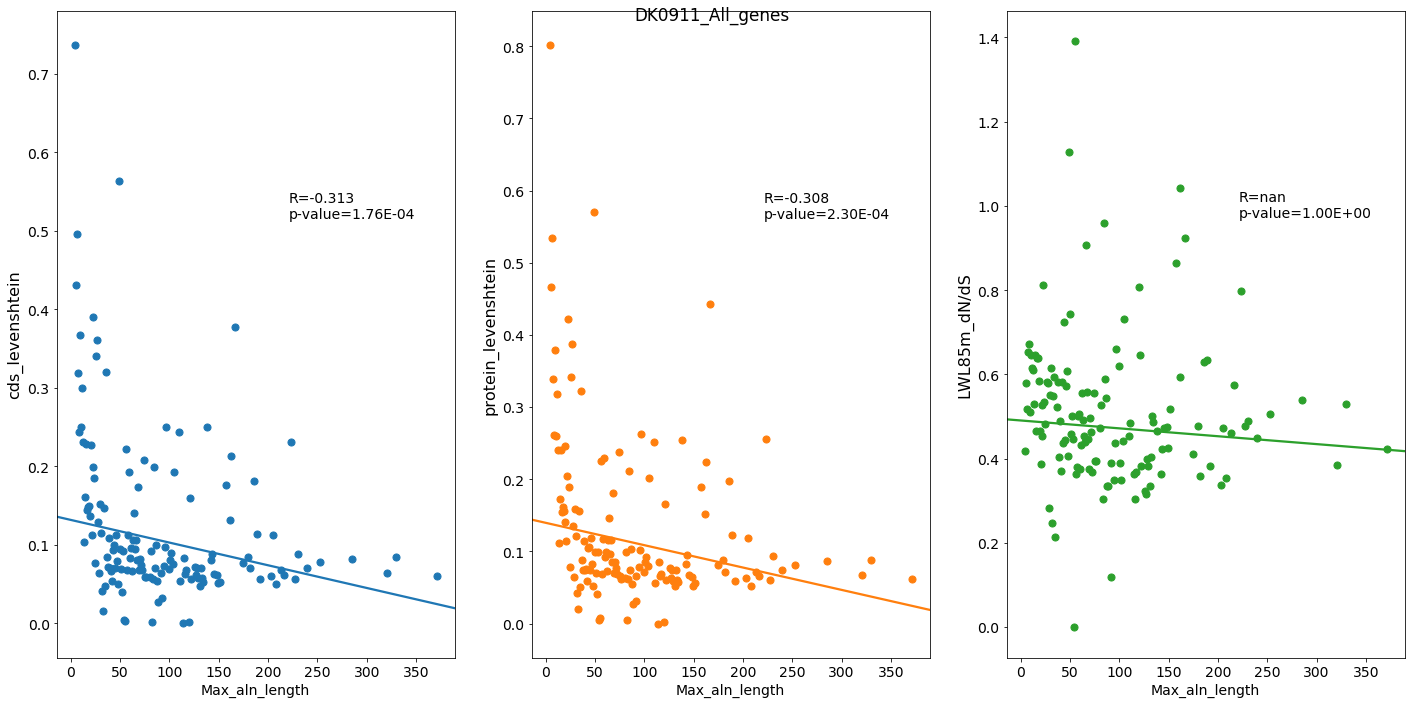

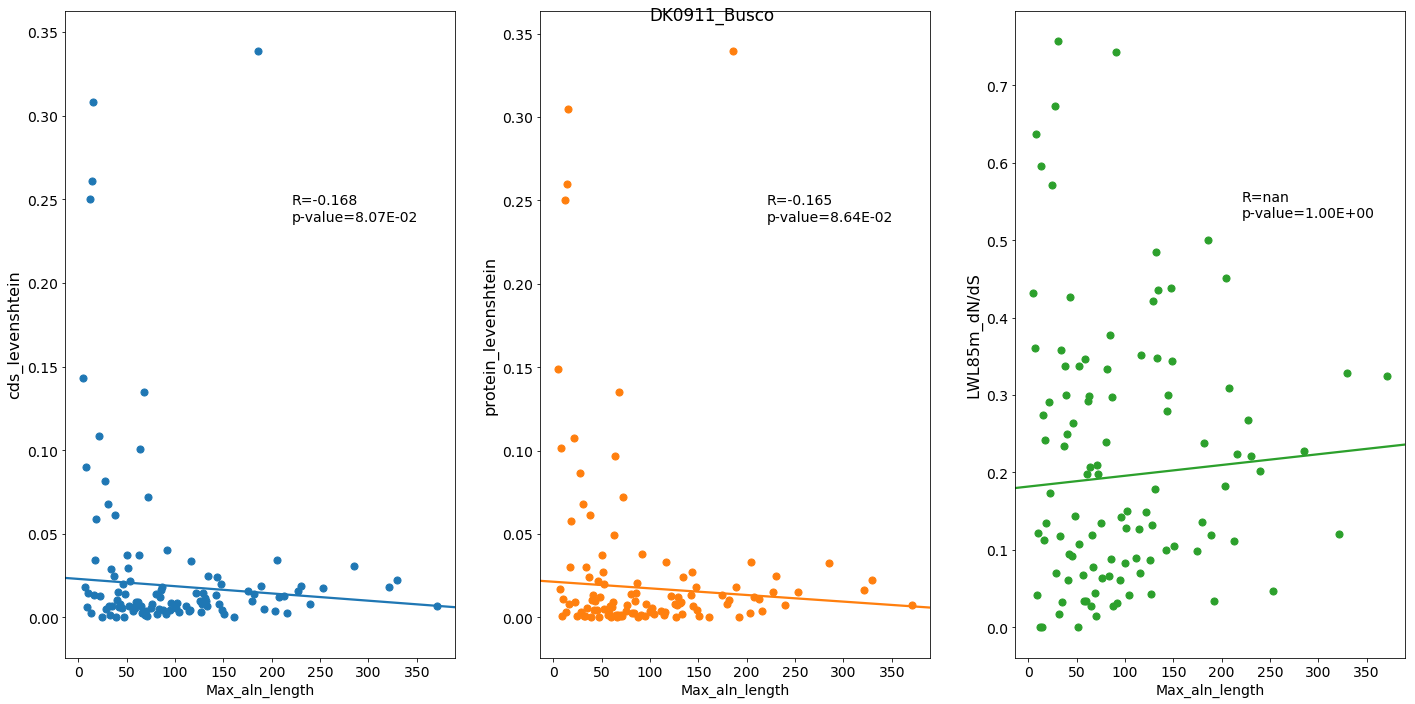

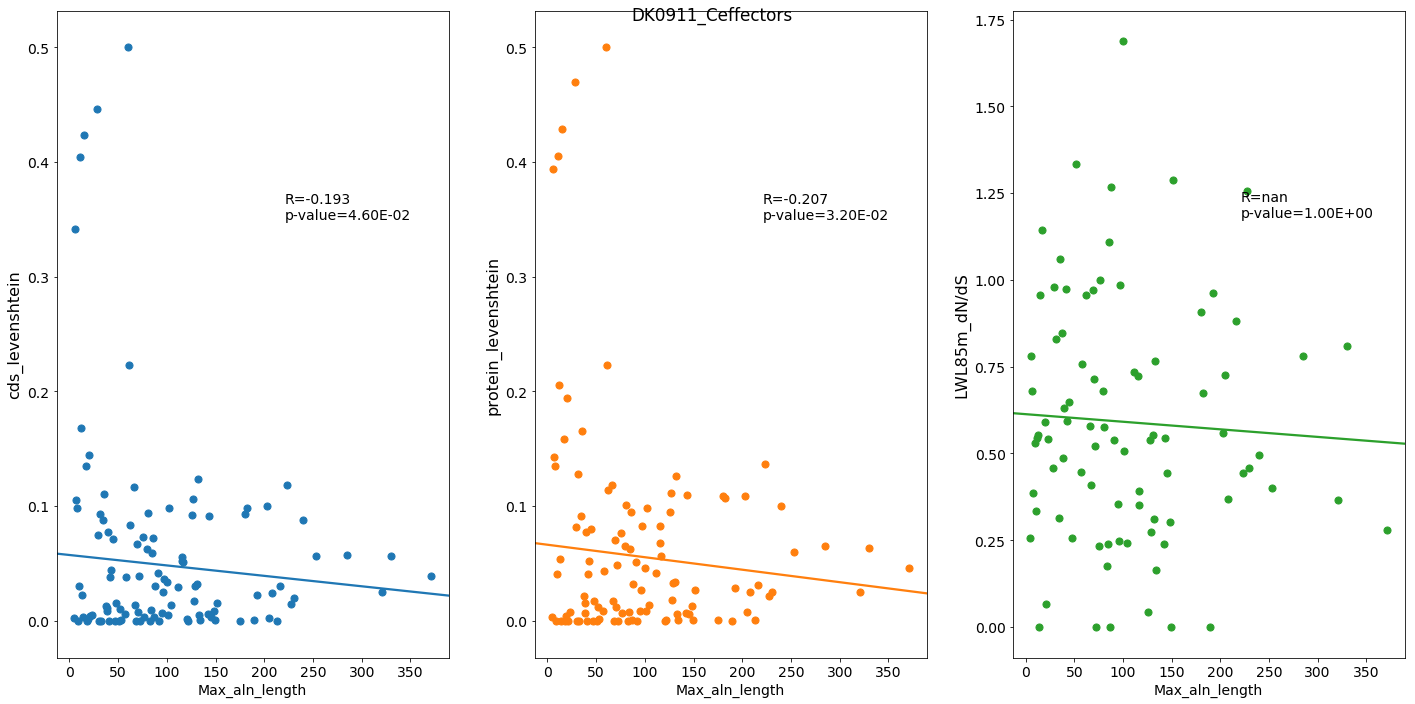

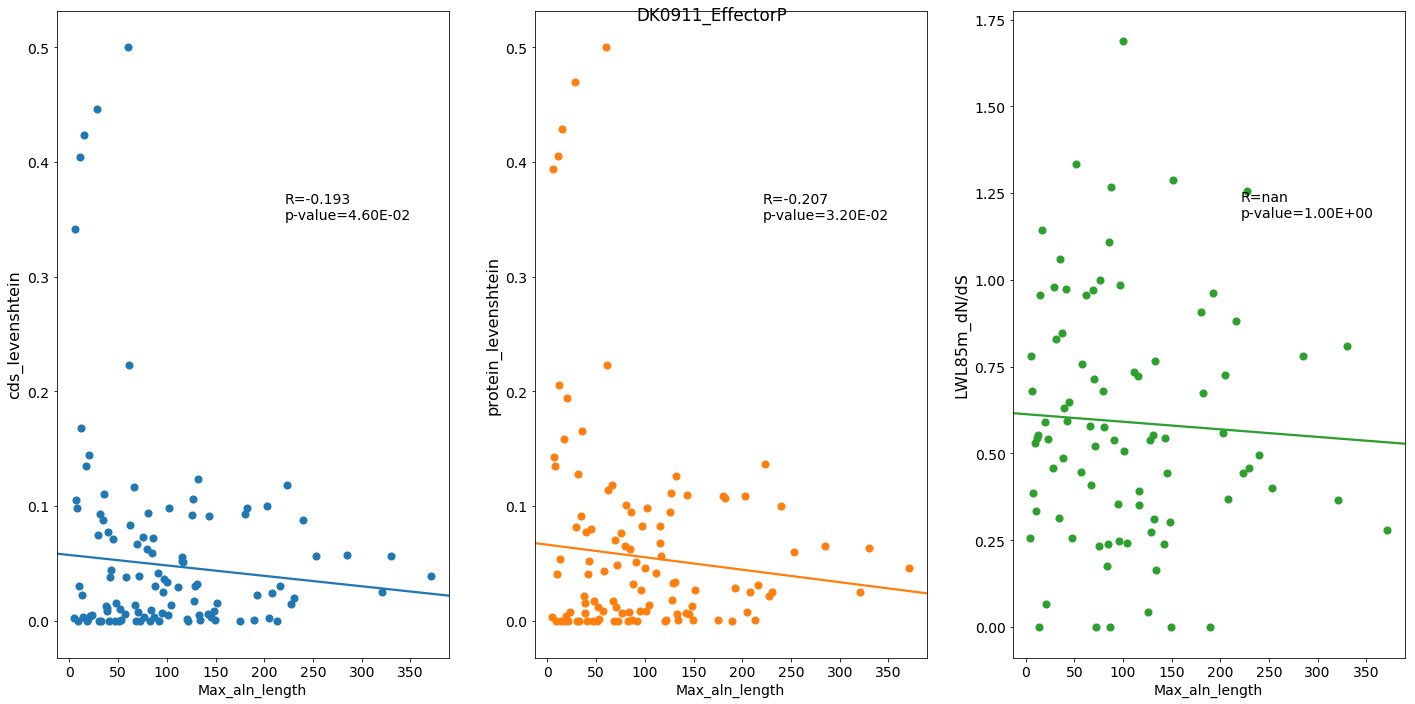

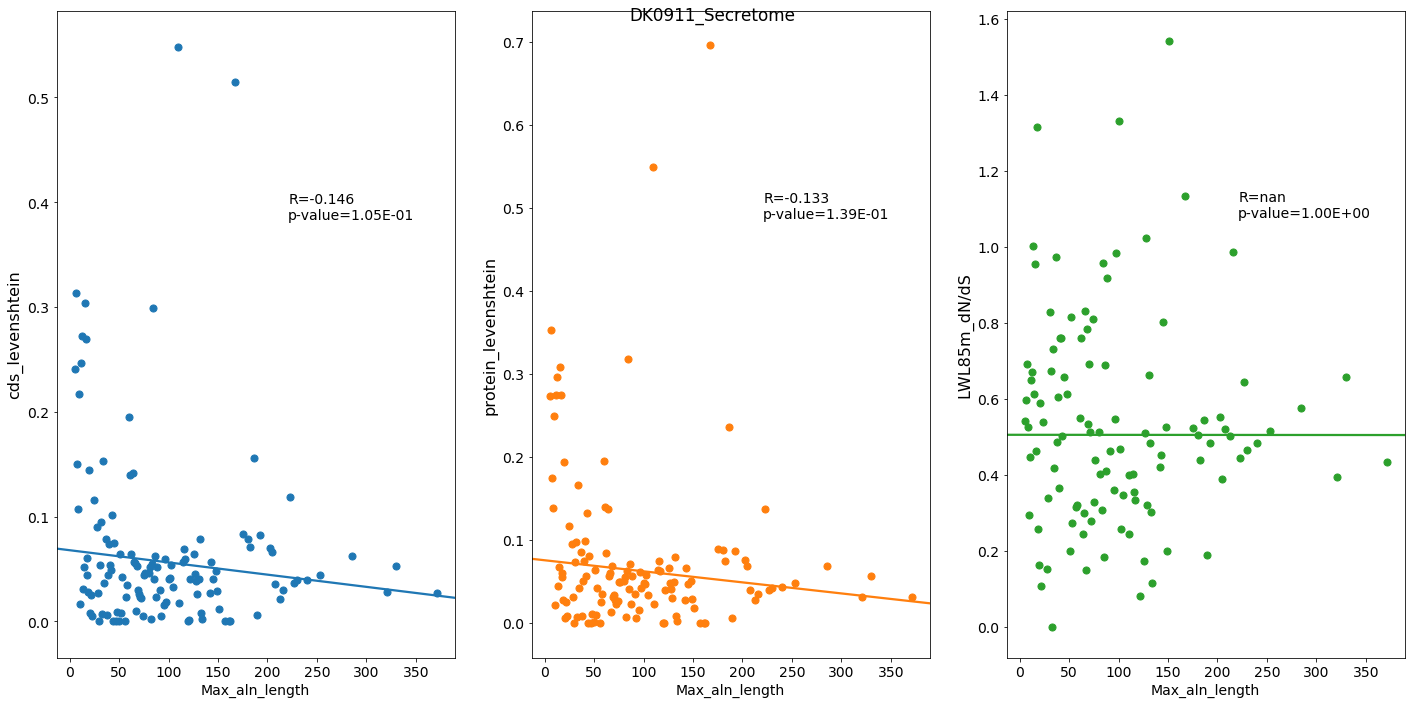

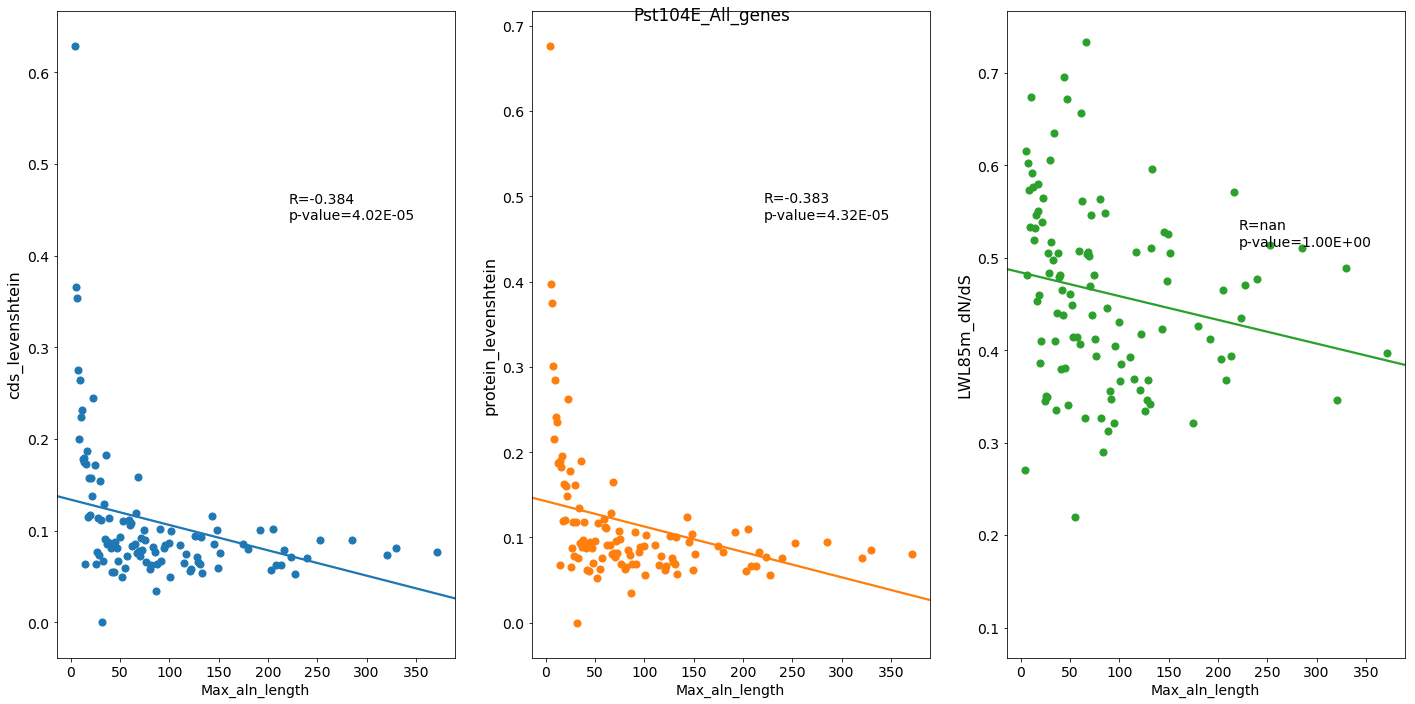

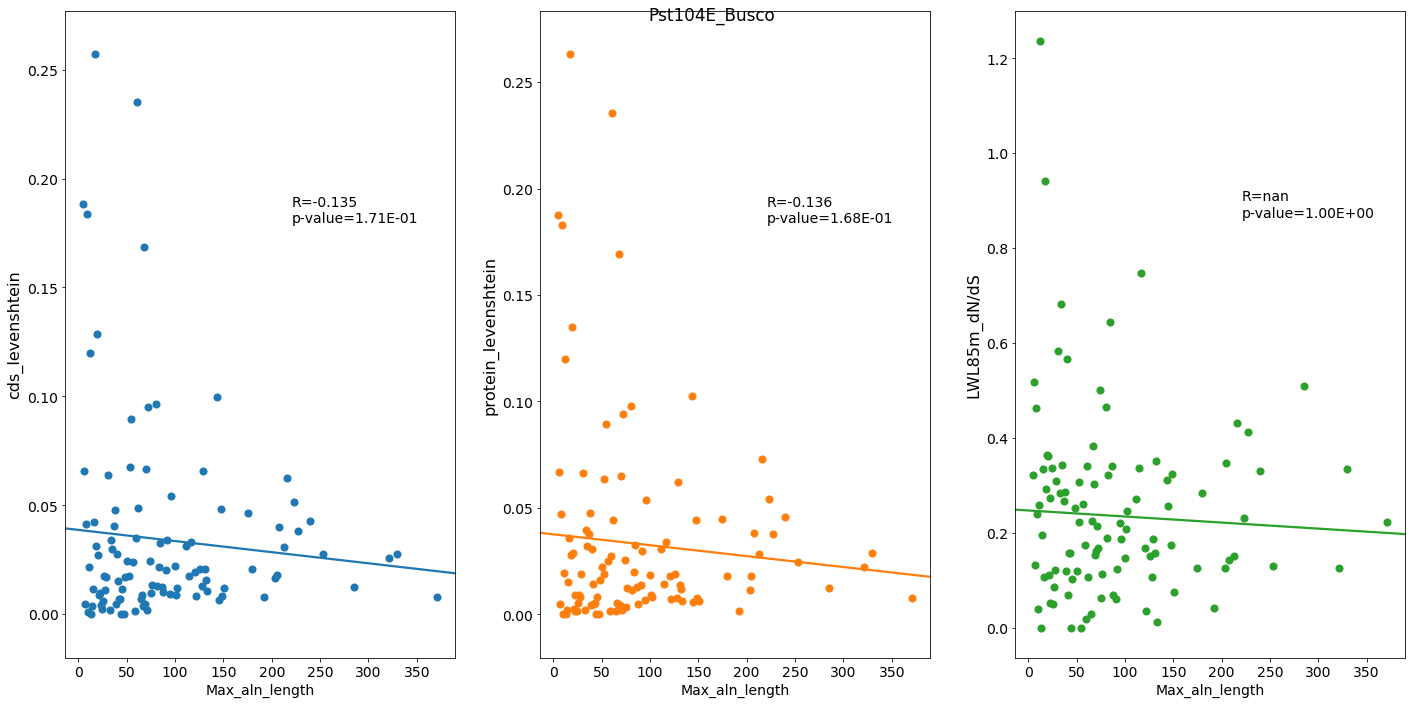

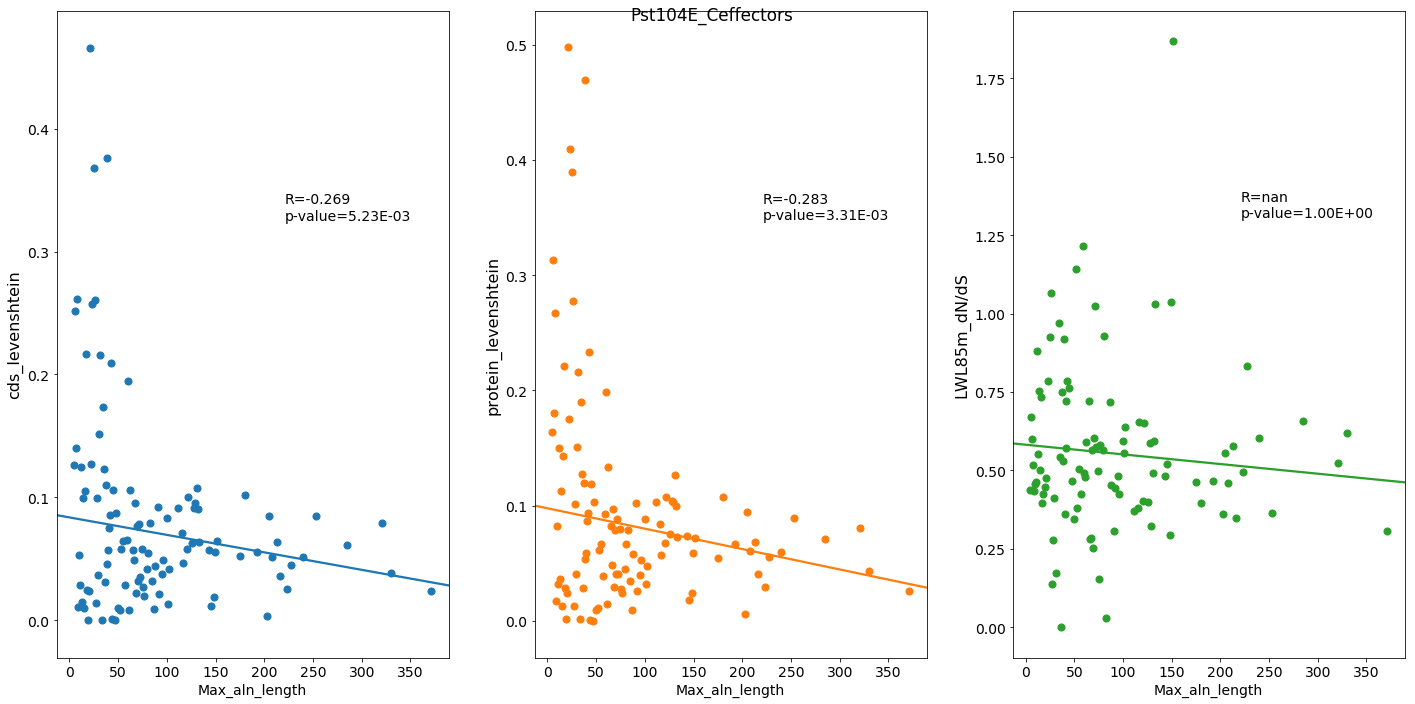

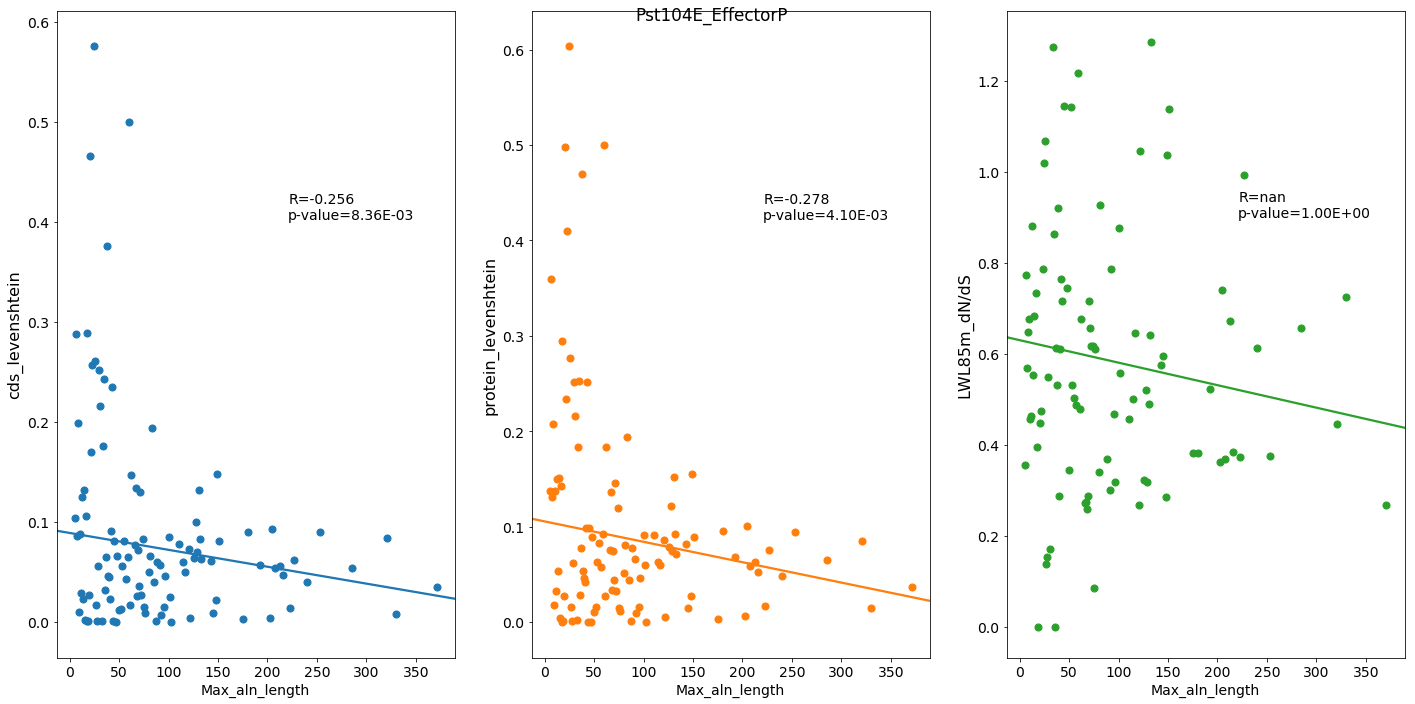

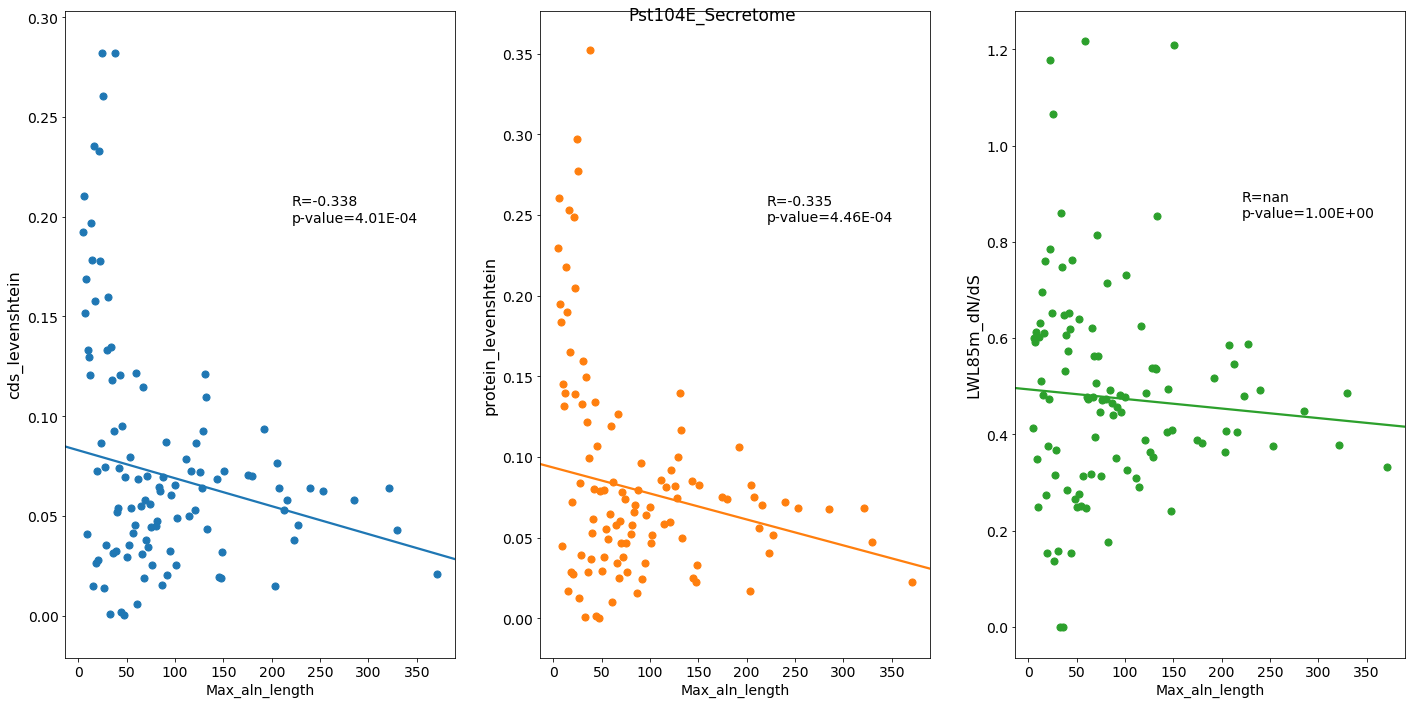

In [624]:
#this approach wasn't correct as the data points are not weight according to sample size. e.g. each point
#representing about the same sample size (qcut does this.)
for genome, genome_dict in zip(genomes, beddicts):
    value_columns = [ 'cds_levenshtein', 'protein_levenshtein', 
       'LWL85m_dN/dS']

    for genetype in gene_keys:
        genetype = '%s_%s' % (genome, genetype)
        tmp_df = GENEMATCHDFDICTv2[genome]
        tmp_df_columns = []
        tmp_df_columns.append(genome)
        tmp_df_columns = tmp_df_columns + value_columns
        tmp_df_columns.append(genetype)
        tmp_df_columns.append('Max_aln_length')
        print(genetype, value)
        #print(pearsonr(tmp_df.Max_aln_length, tmp_df[value]))
        plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],value_columns, genetype,\
                             genome_dict["Primary_genes"],  color, 'something')

DK0911_All_genes protein_levenshtein
(-0.41116971719514872, 0.0093129721902975651)
(-0.41363092999394968, 0.0088585375832263141)
(-0.27264050478229801, 0.093108407681229591)
DK0911_Busco protein_levenshtein


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-0.098639842432060962, 0.55573754916147444)
(-0.065833178179730945, 0.69454631936735067)
(0.16691887130667771, 0.31652031664789149)
DK0911_Ceffectors protein_levenshtein


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(0.0031172673311240227, 0.98539090748333635)
(-0.029723901416920655, 0.86136547916997264)
(-0.091132446914725537, 0.59166195447880154)
DK0911_EffectorP protein_levenshtein


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(0.0031172673311240227, 0.98539090748333635)
(-0.029723901416920655, 0.86136547916997264)
(-0.091132446914725537, 0.59166195447880154)
DK0911_Secretome protein_levenshtein


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-0.17525042699369478, 0.27941599752472773)
(-0.18807456710985146, 0.24516388896671909)
(0.072840934763432105, 0.65511164940623989)


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Pst104E_All_genes protein_levenshtein
(-0.47241983277196181, 0.0023919034106324433)
(-0.47117586728985533, 0.0024650630562242262)
(-0.37685993941219237, 0.01803737633212615)
Pst104E_Busco protein_levenshtein


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-0.031028154662938873, 0.84926041554218201)
(-0.040148762667566534, 0.80570524935842114)
(-0.10933630275719035, 0.50184234534195671)
Pst104E_Ceffectors protein_levenshtein


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-0.27654362996268173, 0.088336154893353266)
(-0.32605457290660383, 0.042796024231046503)
(-0.25105844186548432, 0.12315673754683644)
Pst104E_EffectorP protein_levenshtein


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-0.25775305719237535, 0.11314909698978828)
(-0.31317056952242395, 0.05222637274446839)
(-0.2895859341320362, 0.073750385628340423)
Pst104E_Secretome protein_levenshtein


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-0.40276550781886533, 0.0099748261369426178)
(-0.40893045898981023, 0.0087941777748100497)
(-0.18504301233556969, 0.25299312844736954)


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


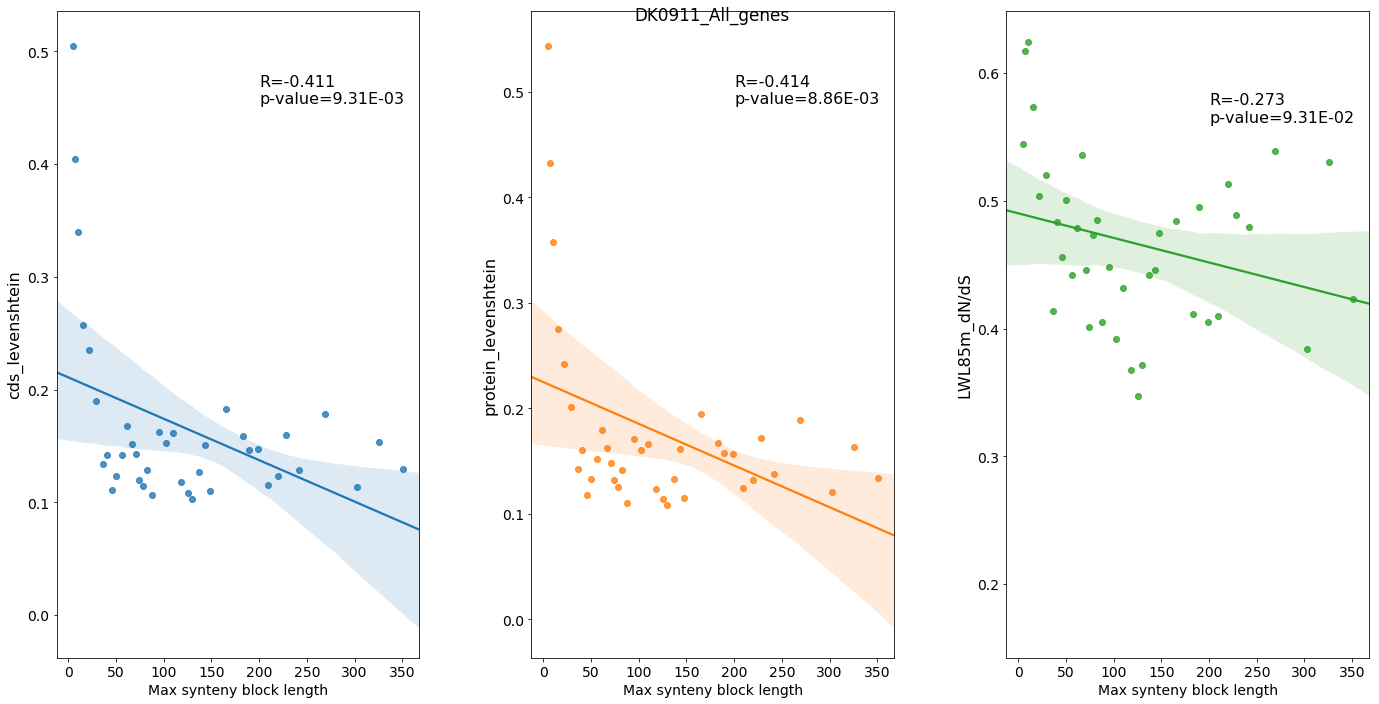

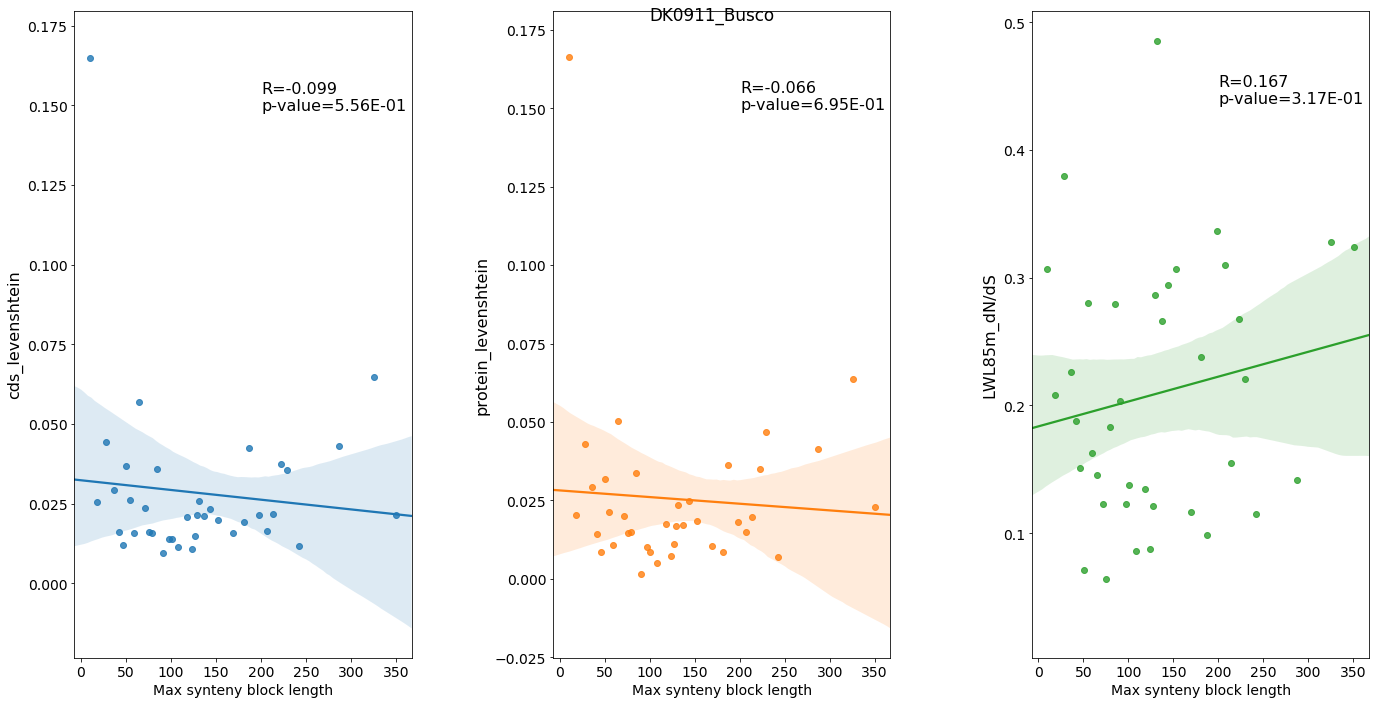

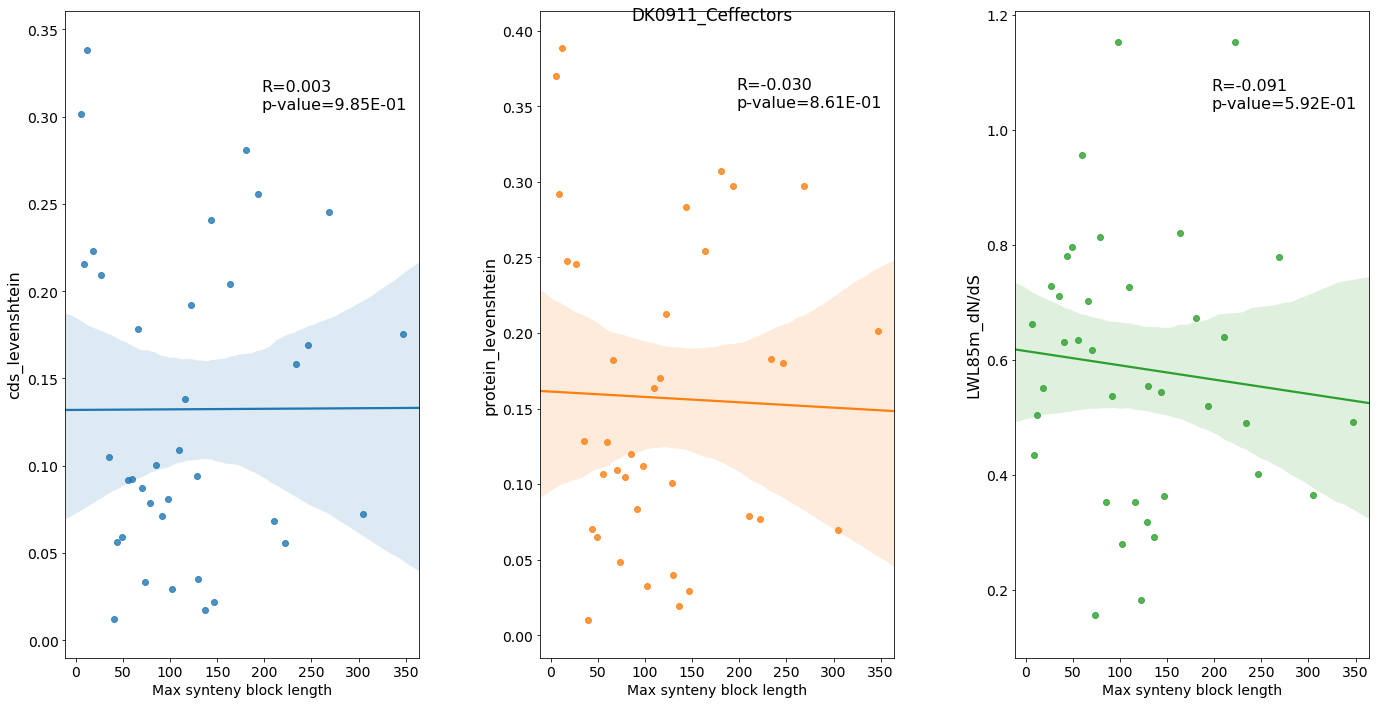

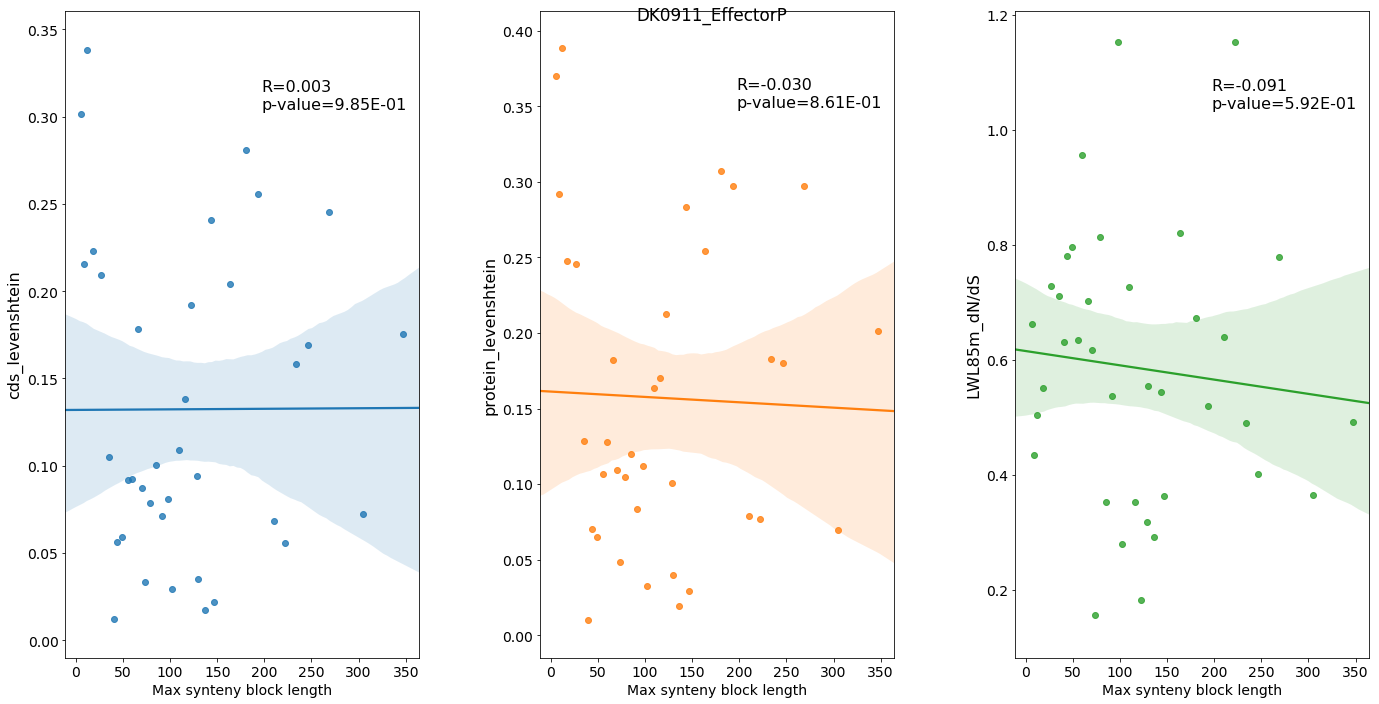

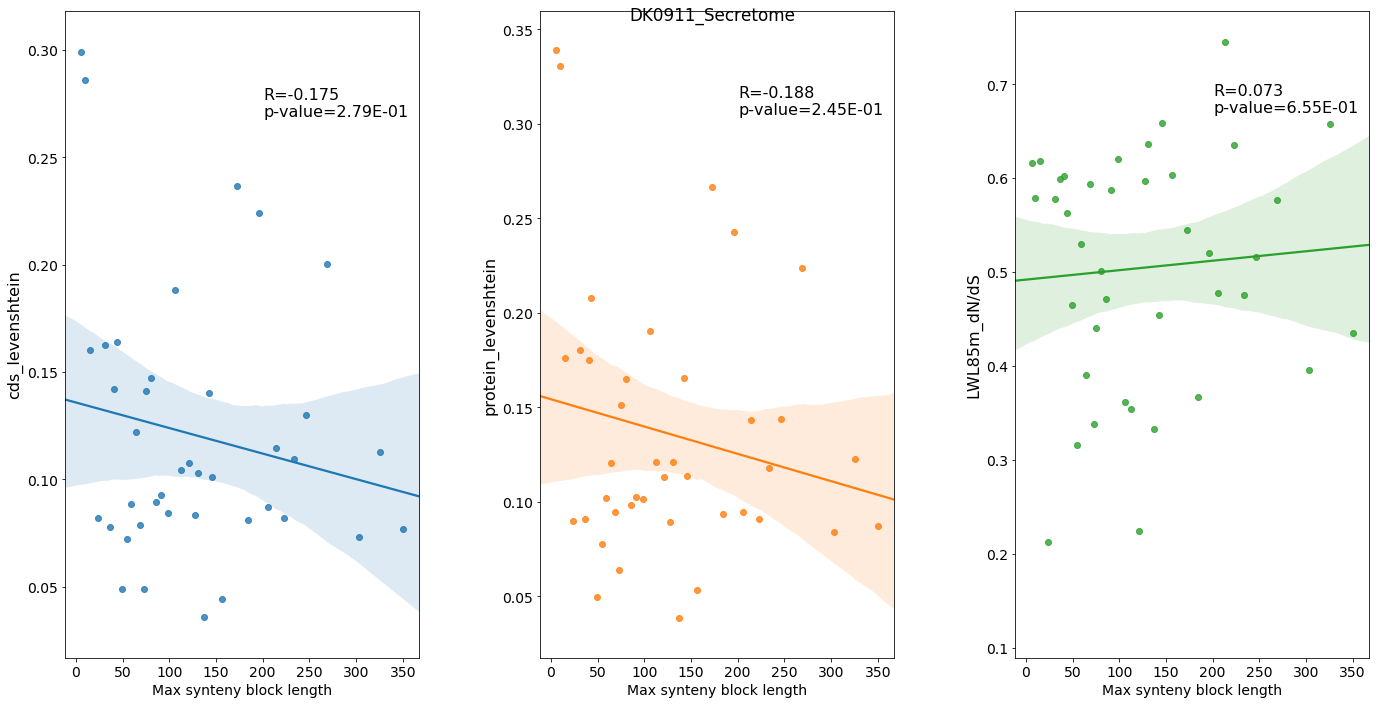

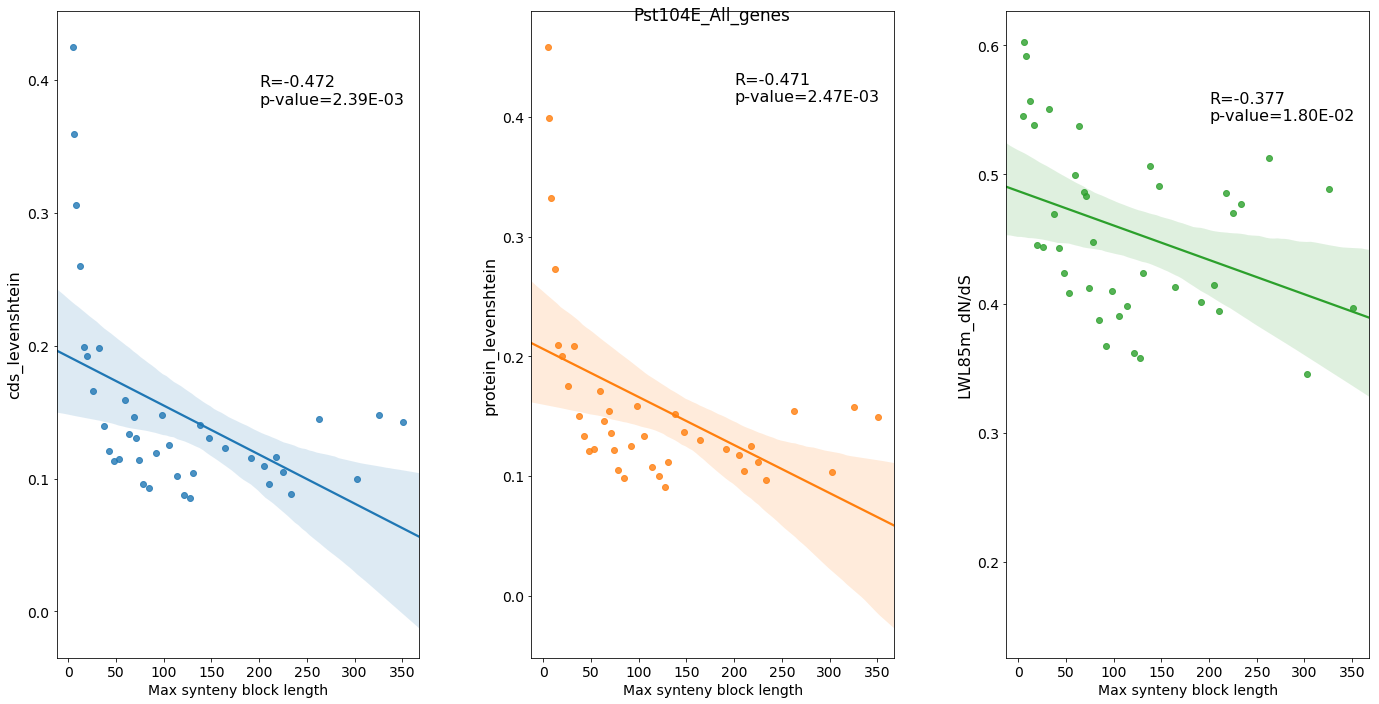

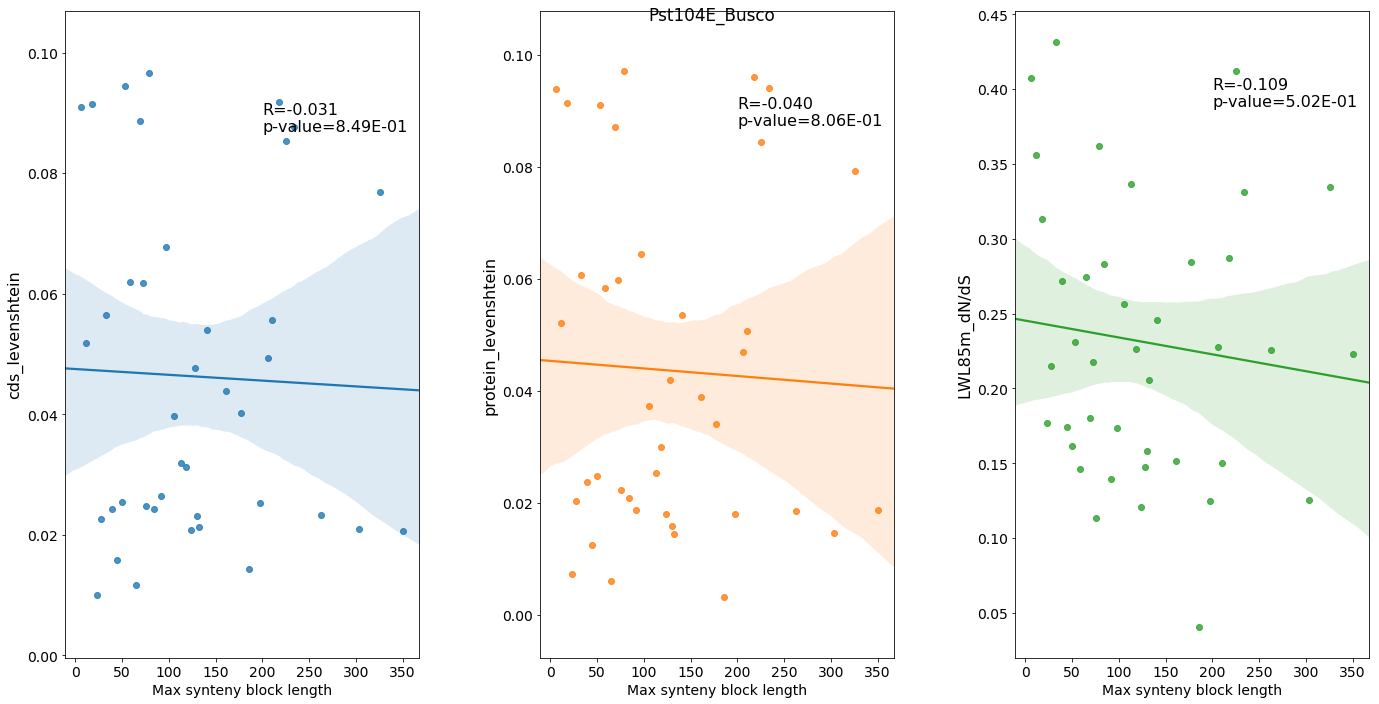

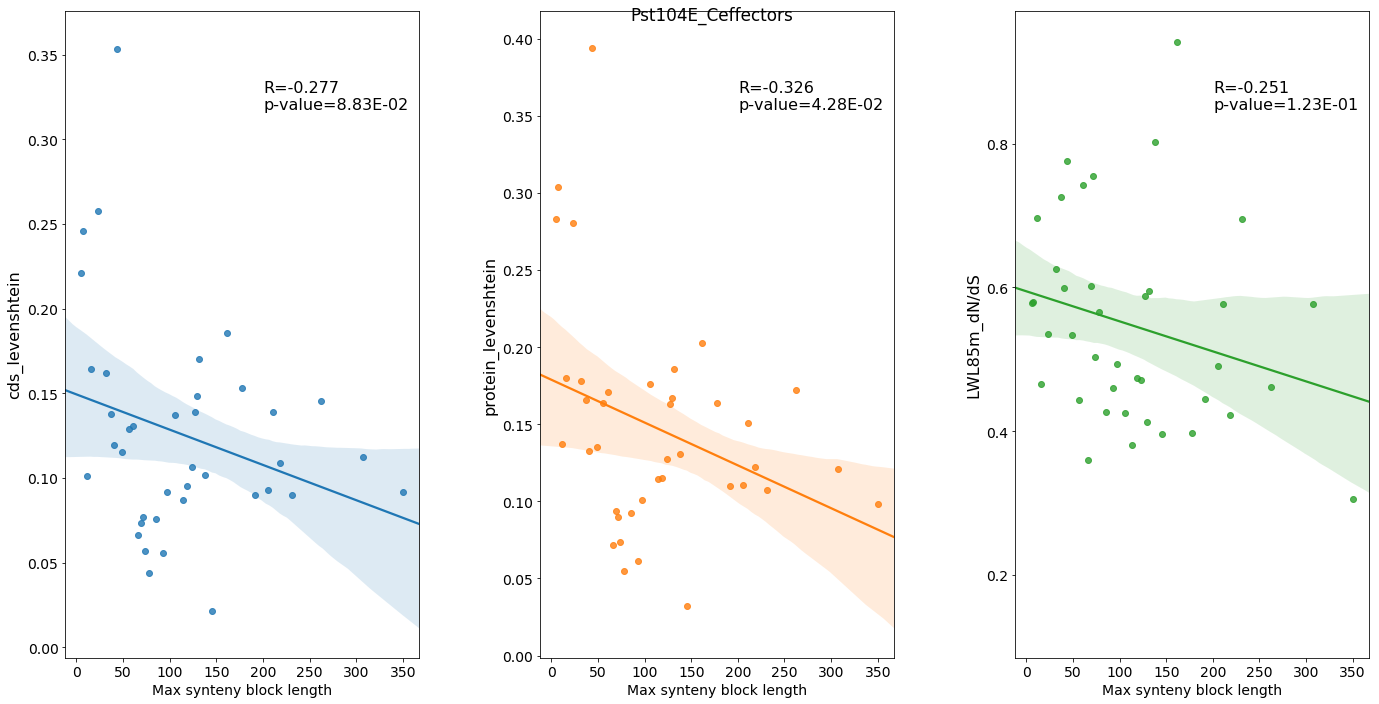

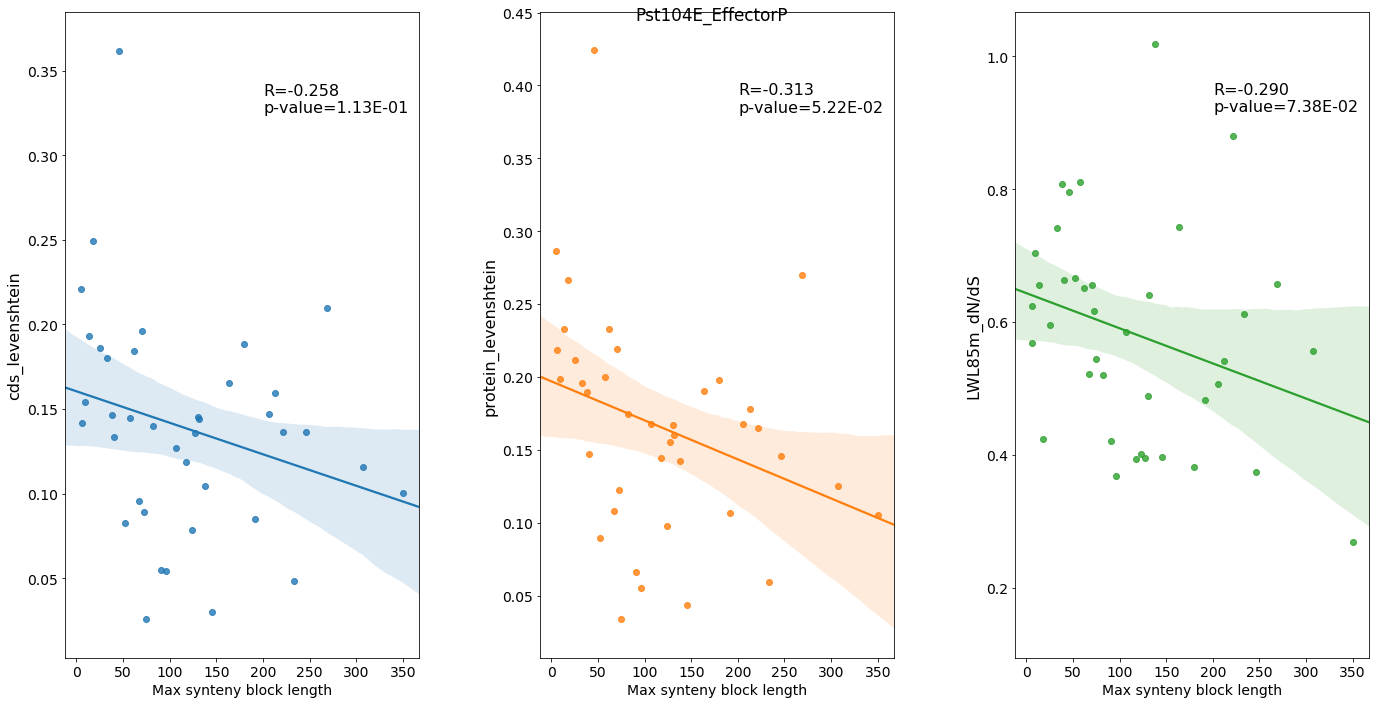

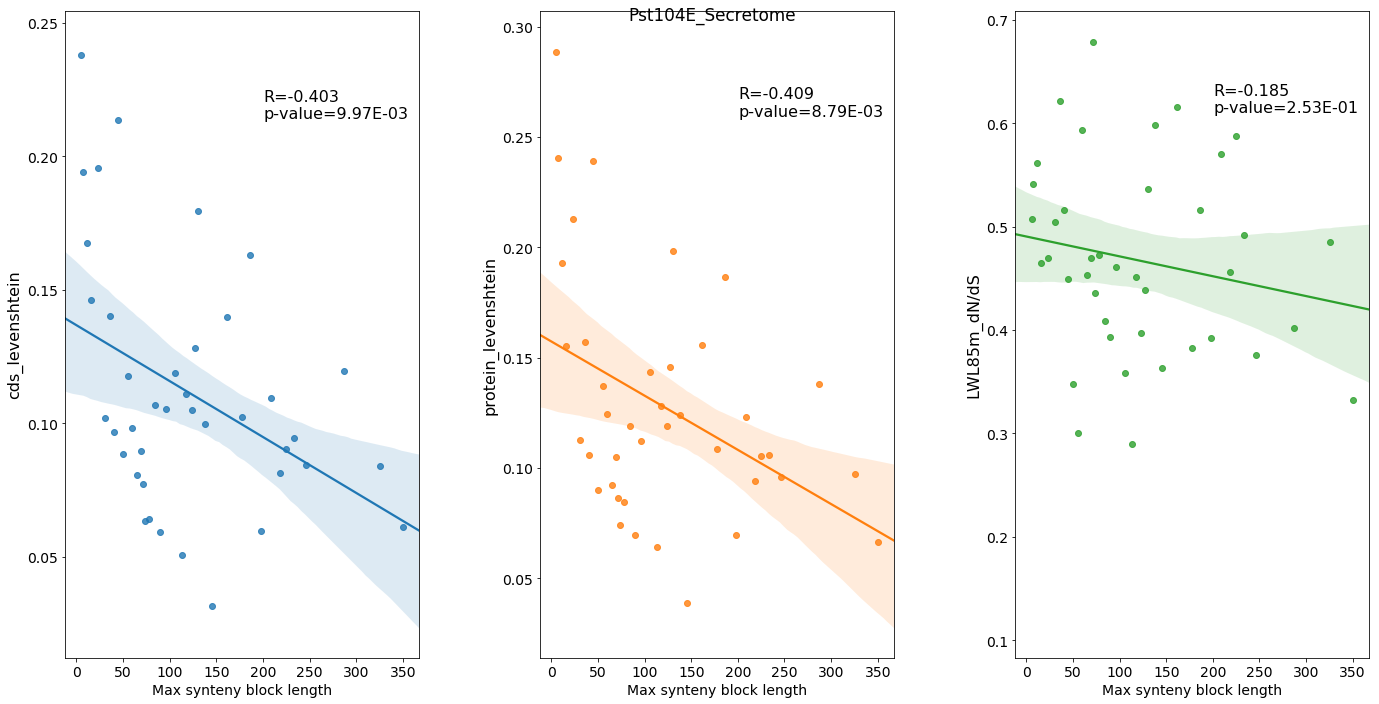

In [644]:
for genome, genome_dict in zip(genomes, beddicts):
    value_columns = [ 'cds_levenshtein', 'protein_levenshtein', 
       'LWL85m_dN/dS']

    for genetype in gene_keys:
        genetype = '%s_%s' % (genome, genetype)
        tmp_df = GENEMATCHDFDICTv2[genome]
        tmp_df_columns = []
        tmp_df_columns.append(genome)
        tmp_df_columns = tmp_df_columns + value_columns
        tmp_df_columns.append(genetype)
        tmp_df_columns.append('Max_aln_length')
        print(genetype, value)
        #print(pearsonr(tmp_df.Max_aln_length, tmp_df[value]))
        plot_correlation_qcut(genome, tmp_df.loc[:, tmp_df_columns],value_columns, genetype,\
                             genome_dict["Primary_genes"],  color, 'something')

### Test coding below.

(nan, 1.0)


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(nan, 1.0)


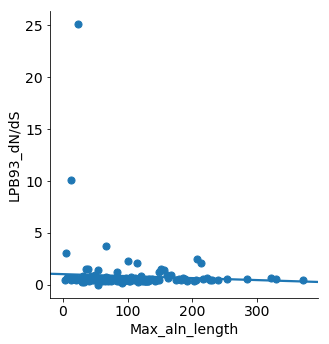

In [462]:
genome = "DK0911"
value = 'LPB93_dN/dS'
genetype = 'DK0911_All_genes'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
print(pearsonr(tmp_df.groupby('Max_aln_length')[value].mean(), index_array[:-1]))
#print(pearsonr(tmp_df.Max_aln_length, tmp_df[value]))
plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],[value], genetype,\
                 DK0911_dict["Primary_genes"],  color, 'something')

(-0.28240656643376055, 0.00079098526411835633)
(nan, 1.0)


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


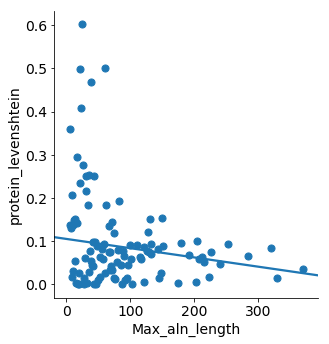

In [456]:
genome = "Pst104E"
value = 'protein_levenshtein'
genetype = 'Pst104E_EffectorP'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
tmp_df = tmp_df[tmp_df[genetype]]
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
print(pearsonr(tmp_df.groupby('Max_aln_length')[value].mean(), index_array[:-1]))
print(pearsonr(tmp_df['Max_aln_length'], tmp_df[tmp_df[genetype]][value]))
plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],[value], genetype,\
                 Pst_104E_dict["Primary_genes"],  color, 'something')

In [399]:

genome = "Pst104E"
value = 'protein_levenshtein'
genetype = 'Pst104E_EffectorP'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
tmp_df = tmp_df[tmp_df[genetype]]
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
print(pearsonr(tmp_df.groupby('Max_aln_length')[value].mean(), index_array[:-1]))
print(pearsonr(tmp_df['Max_aln_length'], tmp_df[tmp_df[genetype]][value]))
plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],[value], genetype,\
                 Pst_104E_dict["Primary_genes"],  color, 'something')

Index(['Pst104E', 'DK0911', 'protein_hamming', 'protein_levenshtein',
       'cds_hamming', 'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS',
       'LWL85m_dN/dS', 'LPB93_dN/dS', 'DK0911_All_genes', 'DK0911_Busco',
       'DK0911_Ceffectors', 'DK0911_EffectorP', 'DK0911_Secretome',
       'Pst104E_All_genes', 'Pst104E_Busco', 'Pst104E_Ceffectors',
       'Pst104E_EffectorP', 'Pst104E_Secretome', 'Match_type',
       'Max_aln_length'],
      dtype='object')

In [626]:
genome = "Pst104E"
value = 'protein_levenshtein'
genetype = 'Pst104E_Busco'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
tmp_df = tmp_df[tmp_df[genetype]]
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
print(pearsonr(tmp_df.groupby('Max_aln_length')[value].mean(), index_array[:-1]))
print(pearsonr(tmp_df['Max_aln_length'], tmp_df[tmp_df[genetype]][value]))
#plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],[value], genetype,\
                # Pst_104E_dict["Primary_genes"],  color, 'something')

(-0.20988744758712405, 0.01348194259349053)
(nan, 1.0)


[5.9994999999999994, 8.0, 10.5, 13.5, 16.0, 18.0, 20.5, 24.0, 28.0, 31.0, 33.5, 36.5, 39.491500000000002, 41.991500000000002, 44.0, 46.5, 49.5, 52.0, 54.0, 56.5, 59.5, 62.5, 65.5, 68.0, 70.0, 73.0, 75.5, 78.5, 83.0, 86.5, 91.633499999999998, 96.133499999999998, 99.0, 103.0, 107.5, 112.0, 115.0, 118.5, 123.5, 127.0, 130.0, 135.0, 141.5, 148.75, 157.25, 168.5, 177.5, 181.0, 185.5, 196.0, 205.5, 210.5, 218.0, 225.0, 233.5, 262.5, 303.0, 346.0]
(-0.32477264615011991, 0.012868677459526818)
(-0.13383292760582305, 0.31655211960638846)


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


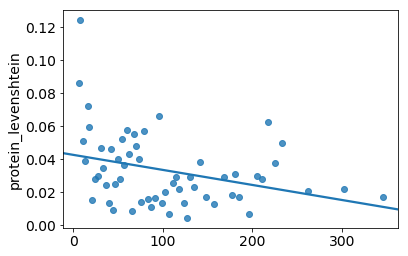

In [639]:
df = tmp_df.loc[:, tmp_df_columns]
df.dropna(inplace=True)
genome = "Pst104E"
value = 'protein_levenshtein'
genetype = 'Pst104E_Busco'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
tmp_df = tmp_df[tmp_df[genetype]]
df['Max_length_category'] = pd.qcut(df.Max_aln_length, q= 60, duplicates='drop')
mid_points = [x.mid for x in df.groupby('Max_length_category')[value].mean().index]
interval_means = df.groupby('Max_length_category')[value].mean()
interval_medians = df.groupby('Max_length_category')[value].median()
print(mid_points)
print(pearsonr(interval_means, mid_points))
print(pearsonr(interval_medians, mid_points))
sns.regplot(x=mid_points, y=interval_means,\
                    ci=None)

In [640]:
df.groupby('Max_length_category')[value].count()

Max_length_category
(4.999, 7.0]      62
(7.0, 9.0]        35
(9.0, 12.0]       46
(12.0, 15.0]      56
(15.0, 17.0]      34
(17.0, 19.0]      39
(19.0, 22.0]      43
(22.0, 26.0]      47
(26.0, 30.0]      47
(30.0, 32.0]      40
(32.0, 35.0]      41
(35.0, 38.0]      45
(38.0, 40.983]    42
(40.983, 43.0]    61
(43.0, 45.0]      45
(45.0, 48.0]      51
(48.0, 51.0]      39
(51.0, 53.0]      60
(53.0, 55.0]      13
(55.0, 58.0]      60
(58.0, 61.0]      31
(61.0, 64.0]      48
(64.0, 67.0]      64
(67.0, 69.0]      26
(69.0, 71.0]      81
(71.0, 75.0]      64
(75.0, 76.0]      51
(76.0, 81.0]      32
(81.0, 85.0]      46
(85.0, 88.0]      36
(88.0, 95.267]    36
(95.267, 97.0]    66
(97.0, 101.0]     29
(101.0, 105.0]    48
(105.0, 110.0]    40
(110.0, 114.0]    45
(114.0, 116.0]    41
(116.0, 121.0]    57
(121.0, 126.0]    39
(126.0, 128.0]    39
(128.0, 132.0]    43
(132.0, 138.0]    50
(138.0, 145.0]    45
(145.0, 152.5]    35
(152.5, 162.0]    54
(162.0, 175.0]    56
(175.0, 180.0]

In [595]:
tmp_list = df.protein_levenshtein.unique().tolist()
tmp_list.sort()
tmp_list

[0.0,
 0.0003,
 0.0004,
 0.0005,
 0.0006,
 0.0007,
 0.0008,
 0.0009,
 0.001,
 0.0011,
 0.0012,
 0.0013,
 0.0014,
 0.0015,
 0.0016,
 0.0017,
 0.0018,
 0.0019,
 0.002,
 0.0021,
 0.0022,
 0.0023,
 0.0024,
 0.0025,
 0.0026,
 0.0027,
 0.0028,
 0.0029,
 0.003,
 0.0031,
 0.0032,
 0.0033,
 0.0034,
 0.0035,
 0.0036,
 0.0037,
 0.0038,
 0.0039,
 0.004,
 0.0041,
 0.0042,
 0.0043,
 0.0044,
 0.0045,
 0.0046,
 0.0047,
 0.0048,
 0.0049,
 0.005,
 0.0051,
 0.0052,
 0.0053,
 0.0054,
 0.0055,
 0.0056,
 0.0057,
 0.0058,
 0.0059,
 0.006,
 0.0061,
 0.0062,
 0.0063,
 0.0064,
 0.0065,
 0.0066,
 0.0067,
 0.0068,
 0.0069,
 0.006999999999999999,
 0.0071,
 0.0072,
 0.0073,
 0.0074,
 0.0075,
 0.0076,
 0.0077,
 0.0078,
 0.008,
 0.0081,
 0.0082,
 0.0083,
 0.0084,
 0.0085,
 0.0086,
 0.0087,
 0.0088,
 0.0089,
 0.009000000000000001,
 0.0091,
 0.0092,
 0.0093,
 0.0094,
 0.0095,
 0.0096,
 0.0097,
 0.0098,
 0.0099,
 0.01,
 0.0101,
 0.0102,
 0.0103,
 0.0104,
 0.0106,
 0.0107,
 0.0108,
 0.0109,
 0.0111,
 0.0112,
 0.0113,
 0.

In [583]:
mid_points = [x.mid for x in df.groupby('Max_length_category')[value].mean().index]

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


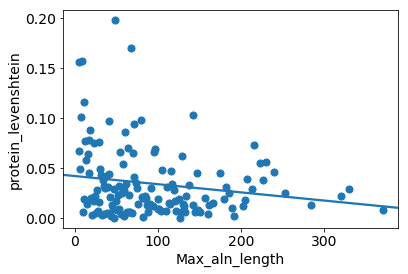

In [515]:
sns.regplot(x='Max_aln_length', y=value, data=tmp_df.loc[:, tmp_df_columns], y_jitter=.05,\
                    x_estimator=np.mean, ci=None)

In [375]:
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
index_array[:-1]

array([   4.,    5.,    6.,    7.,    8.,    9.,   10.,   11.,   12.,
         13.,   14.,   15.,   16.,   17.,   18.,   19.,   20.,   21.,
         22.,   23.,   24.,   25.,   26.,   27.,   28.,   29.,   30.,
         31.,   32.,   33.,   34.,   35.,   36.,   37.,   38.,   39.,
         40.,   41.,   42.,   43.,   44.,   45.,   46.,   47.,   48.,
         49.,   50.,   51.,   52.,   53.,   54.,   55.,   56.,   57.,
         58.,   59.,   60.,   61.,   62.,   63.,   64.,   65.,   66.,
         67.,   68.,   69.,   70.,   71.,   72.,   74.,   75.,   76.,
         80.,   81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,
         91.,   92.,   95.,   96.,   97.,  100.,  101.,  102.,  104.,
        105.,  110.,  111.,  114.,  115.,  116.,  117.,  120.,  121.,
        122.,  126.,  127.,  128.,  129.,  131.,  132.,  133.,  134.,
        138.,  142.,  143.,  145.,  148.,  149.,  151.,  157.,  161.,
        162.,  167.,  175.,  180.,  182.,  186.,  189.,  192.,  203.,
        205.,  208.,

In [367]:
tmp_df.groupby('Max_aln_length')[value].mean()

Max_aln_length
4.0      0.340031
5.0      0.529803
6.0      0.491519
7.0      0.561120
8.0      0.526189
9.0      0.522548
10.0     0.540574
11.0     0.532434
12.0     0.475343
13.0     0.408063
14.0     0.469397
15.0     0.372738
16.0     0.448219
17.0     0.452970
18.0     0.437821
19.0     0.407786
20.0     0.334792
21.0     0.459090
22.0     0.541593
23.0     0.514096
24.0     0.387033
25.0     0.489186
26.0     0.289832
27.0     0.365357
28.0     0.456109
29.0     0.505559
30.0     0.546579
31.0     0.404146
32.0     0.329674
33.0     0.549908
           ...   
142.0    0.395304
143.0    0.489751
145.0    0.564869
148.0    0.428716
149.0    0.485868
151.0    0.477631
157.0    0.548964
161.0    0.418636
162.0    0.399691
167.0    0.402837
175.0    0.290174
180.0    0.402296
182.0    0.510708
186.0    0.433546
189.0    0.413807
192.0    0.394535
203.0    0.372136
205.0    0.437185
208.0    0.370316
213.0    0.386073
216.0    0.468757
223.0    0.408559
227.0    0.444728
230.0    0.42

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


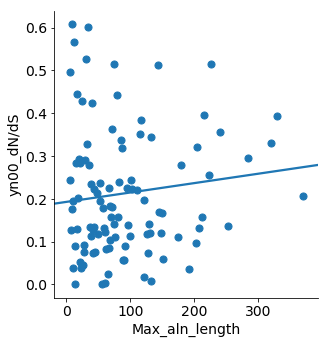

In [363]:
value = 'yn00_dN/dS'
genetype = 'Pst104E_Busco'
tmp_df_columns = []
tmp_df_columns.append("Pst104E")
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length') 
plot_correlation("Pst104E", GENEMATCHDFDICTv2[genome].loc[:, tmp_df_columns],[value], genetype,\
                 Pst_104E_dict["Primary_genes"],  color, 'something')

In [220]:
def max_length(gene, genome):
    if len(tmp_df_maxlength[tmp_df_maxlength[genome] == gene]['aln_length']) > 0:
        return tmp_df_maxlength[tmp_df_maxlength[genome] == gene]['aln_length'].values[0]
    else:
        return np.nan

In [237]:
tmp_df['Max_aln_length']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
        ..
1183   NaN
1184   NaN
1185   NaN
1186   NaN
1187   NaN
1188   NaN
1189   NaN
1190   NaN
1191   NaN
1192   NaN
1193   NaN
1194   NaN
1195   NaN
1196   NaN
1197   NaN
1198   NaN
1199   NaN
1200   NaN
1201   NaN
1202   NaN
1203   NaN
1204   NaN
1205   NaN
1206   NaN
1207   NaN
1208   NaN
1209   NaN
1210   NaN
1211   NaN
1212   NaN
Name: Max_aln_length, Length: 25940, dtype: float64

In [204]:
tmp_df_maxlength.head()

,DK0911,Pst104E,aln_length,aln_name,aln_position,distance_3,distance_5
11,DK0911_00004,Pst104E_18230,230,Alignment 2,0,230,0
12,DK0911_00005,Pst104E_18231,230,Alignment 2,1,229,1
13,DK0911_00006,Pst104E_18232,230,Alignment 2,2,228,2
14,DK0911_00011,Pst104E_18233,230,Alignment 2,3,227,3
15,DK0911_00012,Pst104E_18234,230,Alignment 2,4,226,4


In [212]:
tmp_df.head()

,DK0911,Pst104E,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,...,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst104E_All_genes,Pst104E_Busco,Pst104E_Ceffectors,Pst104E_EffectorP,Pst104E_Secretome,Match_type
0,DK0911_11867,Pst104E_29665,0.0089,0.0089,0.0060,0.0060,0.4038,0.2836,0.5663,0.5663,...,False,False,False,False,False,False,False,False,False,ortho
1,DK0911_20900,Pst104E_00397,0.0127,0.0127,0.0042,0.0042,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,ortho
2,DK0911_25366,Pst104E_10548,0.3269,0.3269,0.3172,0.3118,0.4852,0.4213,0.5298,0.4904,...,False,False,False,False,False,False,False,False,False,ortho
3,DK0911_18001,Pst104E_11378,0.0209,0.0209,0.0124,0.0124,0.7959,0.6034,0.8310,0.8542,...,False,False,False,False,False,False,False,False,False,ortho
4,DK0911_16293,Pst104E_05628,0.4297,0.4297,0.4141,0.4010,0.4103,0.3626,0.7229,0.5225,...,False,False,False,False,False,False,False,False,False,ortho


In [213]:
tmp_df_maxlength[tmp_df_maxlength[genome] == 'DK0911_00005']['aln_length'].values[0]

230

In [200]:
print('hello')

hello


In [197]:
tmp_df[genome].apply(lambda x: tmp_df_maxlength[tmp_df_maxlength[genome] == 'Pst104E_18230']['aln_length'])

KeyboardInterrupt: 

In [201]:
tmp_df_maxlength[tmp_df_maxlength[genome] == 'Pst104E_18230']['aln_length']

Series([], Name: aln_length, dtype: int64)

In [189]:
tmp_df_maxlength[tmp_df_maxlength[genome] == 'Pst104E_18206']

,DK0911,Pst_104E,aln_length,aln_name,aln_position,distance_3,distance_5


In [176]:
GENEMATCHDFDICT[genome]

,Pst104E,DK0911,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,...,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst104E_All_genes,Pst104E_Busco,Pst104E_Ceffectors,Pst104E_EffectorP,Pst104E_Secretome,Match_type
0,Pst104E_18206,DK0911_30030,0.8480,0.8480,0.8423,0.8397,0.7592,0.7774,0.7307,0.7776,...,False,False,False,False,True,False,False,False,False,ortho
1,Pst104E_29488,DK0911_06256,0.2134,0.2134,0.1636,0.1616,0.3598,0.3006,0.3261,0.3828,...,False,False,False,False,True,False,False,False,False,ortho
2,Pst104E_25028,DK0911_13770,0.8104,0.8104,0.8104,0.8104,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho
3,Pst104E_28456,DK0911_12480,0.6893,0.6893,0.6610,0.6573,0.3860,0.3324,0.4684,0.3753,...,False,False,False,False,True,False,False,False,False,ortho
4,Pst104E_06991,DK0911_26923,0.7500,0.7500,0.7280,0.7198,0.2355,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho
5,Pst104E_20069,DK0911_15427,0.5581,0.5548,0.5495,0.5441,0.3424,0.3069,0.3767,0.3791,...,False,False,False,False,True,False,False,False,False,ortho
6,Pst104E_28848,DK0911_16321,0.0005,0.0005,0.0003,0.0003,0.6000,0.2857,0.6000,0.4000,...,False,False,False,False,True,False,False,False,False,ortho
7,Pst104E_04514,DK0911_22088,0.3364,0.3318,0.3272,0.2673,1.0806,1.1575,1.5969,1.4923,...,False,False,False,False,True,False,False,False,False,ortho
8,Pst104E_30155,DK0911_06745,0.2043,0.2043,0.1921,0.1911,0.5778,0.5814,0.6919,0.6545,...,False,False,False,False,True,False,False,False,False,ortho
9,Pst104E_04800,DK0911_10785,0.0000,0.0000,0.0056,0.0056,-0.0000,0.0000,0.0000,0.0000,...,False,False,False,False,True,False,False,False,False,ortho


In [111]:
tmp_df.head()aa

,Pst104E,DK0911,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,...,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst104E_All_genes,Pst104E_Busco,Pst104E_Ceffectors,Pst104E_EffectorP,Pst104E_Secretome,Match_type
0,Pst104E_18206,DK0911_30030,0.8480,0.8480,0.8423,0.8397,0.7592,0.7774,0.7307,0.7776,...,False,False,False,False,True,False,False,False,False,ortho
1,Pst104E_29488,DK0911_06256,0.2134,0.2134,0.1636,0.1616,0.3598,0.3006,0.3261,0.3828,...,False,False,False,False,True,False,False,False,False,ortho
2,Pst104E_25028,DK0911_13770,0.8104,0.8104,0.8104,0.8104,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho
3,Pst104E_28456,DK0911_12480,0.6893,0.6893,0.6610,0.6573,0.3860,0.3324,0.4684,0.3753,...,False,False,False,False,True,False,False,False,False,ortho
4,Pst104E_06991,DK0911_26923,0.7500,0.7500,0.7280,0.7198,0.2355,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho


In [109]:
tmp_df.Match_type.unique()

array(['ortho', 'synteny'], dtype=object)

In [94]:
addondf = pd.DataFrame(columns=tmp_df.columns)

In [97]:
addondf[genome] = pd.Series(list(missing_genes))

In [98]:
addondf

,Pst104E,DK0911,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,DK0911_All_genes,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst104E_All_genes,Pst104E_Busco,Pst104E_Ceffectors,Pst104E_EffectorP,Pst104E_Secretome
0,Pst104E_09469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pst104E_12726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pst104E_17076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Pst104E_02094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pst104E_24095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Pst104E_05655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Pst104E_08225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Pst104E_24085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Pst104E_21117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Pst104E_17823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
missing_genes = set(get_gene_list(bed_dict['All_genes'])) - set(tmp_df[genome].unique()) 

In [88]:
len(missing_genes) 

1288

In [92]:
list(missing_genes)

ValueError: Length of values does not match length of index

In [59]:
dict(zip(['Query', 'Target'], [genome, genomes[-1]] ))

{'Query': 'DK0911', 'Target': 'Pst104E'}

In [60]:
tmp_df.rename(columns= dict(zip(['Query', 'Target'], [genome, genomes[-1]] )))

,DK0911,Pst104E,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS
0,DK0911_11867,Pst104E_29665,0.0089,0.0089,0.0060,0.0060,0.4038,0.2836,0.5663,0.5663
1,DK0911_20900,Pst104E_00397,0.0127,0.0127,0.0042,0.0042,NaN,NaN,NaN,NaN
2,DK0911_25366,Pst104E_10548,0.3269,0.3269,0.3172,0.3118,0.4852,0.4213,0.5298,0.4904
3,DK0911_18001,Pst104E_11378,0.0209,0.0209,0.0124,0.0124,0.7959,0.6034,0.8310,0.8542
4,DK0911_16293,Pst104E_05628,0.4297,0.4297,0.4141,0.4010,0.4103,0.3626,0.7229,0.5225
5,DK0911_12938,Pst104E_08749,0.0629,0.0629,0.0538,0.0449,0.8900,0.7725,0.8544,0.8145
6,DK0911_29815,Pst104E_12994,0.7744,0.7744,0.7783,0.7760,0.2511,0.3581,0.4238,0.4183
7,DK0911_01374,Pst104E_08218,0.4586,0.4586,0.4579,0.4576,0.3506,0.2781,0.3210,0.3082
8,DK0911_07013,Pst104E_29502,0.0377,0.0377,0.0338,0.0338,0.2288,0.1745,0.2616,0.2458
9,DK0911_30684,Pst104E_10572,0.7308,0.7308,0.7289,0.7266,0.5440,0.5505,0.5016,0.5739
